<a id='top'></a>

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# %matplotlib nbagg 
%matplotlib notebook
# %matplotlib inline



## Third party 
import numpy as np
import os, time, zarr, sys
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

import unslice.IO as io
from unslice.utils import *
from unslice.registration.featmatch import *
from unslice.registration.transform import *
from unslice.registration.rigid import *
from unslice.registration.gpu_transform import *
from unslice.registration.utils import *
from unslice.segmentation import *
from unslice.tracing.pyoof import OOF, apply_oof_v2
from unslice.tracing.skel import *
from unslice.flatten import *
from unslice.lightsheetcorrect import *




In [2]:
# Parameters that are constant throughout notebook
working_dir = '/mnt/beegfs/webster/fig3_dfly' 

def bdir(fname):
    return os.path.join(working_dir, fname)

# prefix to add to the beginning of each filename 
name_prefix = '#3-lec' #1
name_prefix2 = '#4-lec' #2

# Table of contents

### Pre-processing
[1. Convert to zarr](#convert)<br>
[2. Downsample](#downsample)<br>
[3. Segment](#segment)<br>
[4. Surface detection](#surfdetect)<br>
[5. Background correction](#background)<br>

### Endpoint detection
[5. Vessel filter](#oof)<br>
[6. Vessel segment](#vessel_segment)<br>
[7. Vessel skeletonization](#skel)<br>
[8. Vessel endpoint detection](#epdetect)<br>

### Surface flattening 
[9. Sample surface](#flatten)<br>
[10. Surface outlier removal](#outlier_surf)<br>
[11. UV map](#uvmap)<br>
[12. Rigid align UV maps](#uvuvalign)<br>
[13. Flatten warp](#flattenwarp)<br>
[14. Flatten warp anchor points, detected points](#pointflatten)<br>

### Transformation (round 1)
[14. Rigid transformation based on manual anchor points](#rigidanchor)<br>
[15. TPS transformation based on manual anchor points (round 0)](#anchorwarp)<br>
[16. Feature match](#featmatch)<br>
[17. TPS transformation (Round 1)](#tpswarp)<br>

[Warp points back, use all at once](#theend)<br>
[Round 2 warp](#round2)<br>

[Tests](#tests)

# Convert to zarr
<a id='convert'></a>

[Return to top](#top)

In [ ]:
# Parameters for converting to zarr

slab_path = '/mnt/beegfs/juhyuk/Dfly/2021-12-24-#3R1.po.lec.gfap.nfh.pv/Channel3_tiffs'
slab_zarr_path = bdir(name_prefix+'.zarr')
pc2_img_size = (31505,18748,414)


## Optional parameters 
load_num_slices = 20 # should be smaller than z chunk size, default None 
resample_num_slices = 1 # number of slices to be processed in one go for resampling, default 1
resample_factor = (0.28,0.28) # original is 0.277 x 0.277 x 1
chunks = (200,200,200) 
num_workers = 20 
file_names = 'img_[0-9]{4}.tiff' # default 'img_[0-9]{4}.tiff'

## crop
zrange = [14,414] # default None
xrange = [0,30200] # default None
yrange = [1700,18300] # default None

## rotate
lateral_rotate_angle = None # default None

## flip
flip = (0,0,0) # default (0,0,0)


#############
start = time.time()
utils.convert_to_zarr_v2(slab_path, slab_zarr_path, pc2_img_size, load_num_slices=load_num_slices,
                        resample_num_slices=resample_num_slices, file_names=file_names, 
                        chunks=chunks, num_workers=num_workers, lateral_rotate_angle=lateral_rotate_angle,
                        flip=flip, crop_xcoords=xrange, crop_ycoords=yrange, crop_zcoords=zrange,
                        resample_factor=resample_factor)
print(time.time()-start, 'seconds elapsed')

Processing chunk x:0-30200, y:1700-18300, z:14-34


  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored



TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored





TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored
100%|██████████| 20/20 [01:38<00:00,  4.90s/it]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 1032/1032 [01:59<00:00,  8.63it/s]

Processing chunk x:0-30200, y:1700-18300, z:34-54



  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored


TiffFile: the 'fastij' argument is ignored




TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored
100%|██████████| 20/20 [01:37<00:00,  4.87s/it]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 1032/1032 [03:31<00:00,  4.88it/s]

Processing chunk x:0-30200, y:1700-18300, z:54-74



  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored


TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored


100%|██████████| 20/20 [02:34<00:00,  7.70s/it]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 1032/1032 [03:15<00:00,  5.27it/s]


Processing chunk x:0-30200, y:1700-18300, z:74-94


  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored


TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

100%|██████████| 20/20 [02:48<00:00,  8.44s/it]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 1032/1032 [04:15<00:00,  4.05it/s]

Processing chunk x:0-30200, y:1700-18300, z:94-114



  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored



TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored




TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

100%|██████████| 20/20 [02:54<00:00,  8.70s/it]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 1032/1032 [03:53<00:00,  4.41it/s]


Processing chunk x:0-30200, y:1700-18300, z:114-134


  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored




TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

100%|██████████| 20/20 [02:44<00:00,  8.24s/it]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 1032/1032 [04:52<00:00,  3.53it/s]

Processing chunk x:0-30200, y:1700-18300, z:134-154



  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored






TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored



TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
100%|██████████| 20/20 [03:05<00:00,  9.26s/it]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 1032/1032 [04:41<00:00,  3.67it/s]

Processing chunk x:0-30200, y:1700-18300, z:154-174



  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored



TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored
100%|██████████| 20/20 [02:41<00:00, 54.66s/it]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 1032/1032 [04:46<00:00,  3.60it/s]

Processing chunk x:0-30200, y:1700-18300, z:174-194



  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored



TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored



TiffFile: the 'fastij' argument is ignored

100%|██████████| 20/20 [02:33<00:00,  7.68s/it]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 1032/1032 [05:29<00:00,  3.13it/s]

Processing chunk x:0-30200, y:1700-18300, z:194-214



  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored









TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored


TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored


TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

100%|██████████| 20/20 [02:37<00:00,  7.87s/it]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 1032/1032 [05:09<00:00,  3.34it/s]


Processing chunk x:0-30200, y:1700-18300, z:214-234


  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored




TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored


TiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored





100%|██████████| 20/20 [01:57<00:00,  5.85s/it]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 1032/1032 [03:35<00:00,  4.79it/s]


Processing chunk x:0-30200, y:1700-18300, z:234-254


  0%|          | 0/20 [00:00<?, ?it/s]TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored
TiffFile: the 'fastij' argument is ignored



TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored

TiffFile: the 'fastij' argument is ignoredTiffFile: the 'fastij' argument is ignored



In [ ]:
# Parameters for converting to zarr

slab_path = '/mnt/beegfs/juhyuk/Dfly/2021-12-25-#4R1.po.lec.gfap.nfh.pv/Channel3_tiffs'
slab_zarr_path = bdir(name_prefix2+'.zarr')
pc2_img_size = (31523,18682,341)


## Optional parameters 
load_num_slices = 20 # should be smaller than z chunk size, default None 
resample_num_slices = 1 # number of slices to be processed in one go for resampling, default 1
resample_factor = (0.28,0.28) # original is 0.277 x 0.277 x 1
chunks = (200,200,200) 
num_workers = 20
file_names = 'img_[0-9]{4}.tiff' # default 'img_[0-9]{4}.tiff'

## crop
zrange = None # default None
xrange = [0,30000] # default None
yrange = [1482,18682] # default None

## rotate
lateral_rotate_angle = None # default None

## flip
flip = (0,0,0) # default (0,0,0)


#############
start = time.time()
utils.convert_to_zarr_v2(slab_path, slab_zarr_path, pc2_img_size, load_num_slices=load_num_slices,
                        resample_num_slices=resample_num_slices, file_names=file_names, 
                        chunks=chunks, num_workers=num_workers, lateral_rotate_angle=lateral_rotate_angle,
                        flip=flip, crop_xcoords=xrange, crop_ycoords=yrange, crop_zcoords=zrange,
                        resample_factor=resample_factor)
print(time.time()-start, 'seconds elapsed')

# Downsample 

<a id='downsample'></a>

[Return to top](#top)

In [ ]:
# top 

source_zarr_path = bdir(name_prefix+'.zarr')
sink_zarr_path = bdir(name_prefix+'_downsampled.zarr')
resample_factor = (0.05, 0.05, 1.0)
chunks = 3*(200,)
num_workers = 24


#####
resample_zarr(source_zarr_path, sink_zarr_path, resample_factor,num_workers=num_workers)

In [ ]:
z = zarr.open(bdir(name_prefix+'_downsampled.zarr'), mode='r')
img = z[:]
io.writeData(bdir(name_prefix+'_downsampled.tif'), img)

In [ ]:
# bottom

source_zarr_path = bdir(name_prefix2+'.zarr')
sink_zarr_path = bdir(name_prefix2+'_downsampled.zarr')
resample_factor = (0.05, 0.05, 1.0)
chunks = 3*(200,)
num_workers = 24


#####
resample_zarr(source_zarr_path, sink_zarr_path, resample_factor,num_workers=num_workers)

In [ ]:
z = zarr.open(bdir(name_prefix2+'_downsampled.zarr'), mode='r')
img = z[:]
io.writeData(bdir(name_prefix2+'_downsampled.tif'), img)

### Change chunk size 

In [ ]:
# Top 
source_zarr_path = bdir(name_prefix+'_downsampled.zarr')
sink_zarr_path = bdir(name_prefix+'_downsampled_.zarr')
new_chunks = 3*(200,)
num_workers = 24

convert_zarr_chunks(source_zarr_path, sink_zarr_path, new_chunks, num_workers=num_workers)

In [ ]:
# Bottom 
source_zarr_path = bdir(name_prefix2+'_downsampled.zarr')
sink_zarr_path = bdir(name_prefix2+'_downsampled_.zarr')
new_chunks = 3*(200,)
num_workers = 24

convert_zarr_chunks(source_zarr_path, sink_zarr_path, new_chunks, num_workers=num_workers)

# Surface detection

## Tissue segmentation
<a id='segment'></a>
[Return to top](#top)

### Top

In [17]:
# Top 
# Parameters to be varied
sample_coord_ranges = [[[0,423],[0,232],[0,400]]]
min_thresholds = [120,130]#*3 # gets rid of background. Pick more or less stringent ones 
saturate_image_thresholds = [200,200] # saturate image threshold
morphopts = [None]*2 #[('close','ball',2)]*3

In [18]:
for i in range(len(min_thresholds)):
    opts = {
        'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels, choose this so that most background that is not tissue is eliminated
        'saturate_image_threshold' : saturate_image_thresholds[i], # if <1, then is a percent of pixels to saturate 
        'k' : 2,
        'alpha' : 25, # make this very high for high smoothness 
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : morphopts[i],
        'sample_coord_ranges' :  sample_coord_ranges # Change this if we want to sample a few slices and see if it's worth processing whole data set on that 
        }
    zarr_path = bdir(name_prefix+'_downsampled_.zarr')
    zarr_segmented_path = bdir('surf_segmentation_tests/segmenttest.zarr')

    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.174423 minutes



100%|██████████| 12/12 [00:27<00:00,  2.30s/it]

Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/beegfs/webster/fig3_dfly/surf_segmentation_tests/segmenttest_thresh120-200_x0_423_y0_232_z0_400_original.tif original red /mnt/beegfs/webster/fig3_dfly/surf_segmentation_tests/segmenttest_thresh120-200_x0_423_y0_232_z0_400_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 0.850230 minutes
Starting image preprocessing..
Saturated image processed in 0.174547 minutes



100%|██████████| 12/12 [00:27<00:00,  2.31s/it]

Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/beegfs/webster/fig3_dfly/surf_segmentation_tests/segmenttest_thresh130-200_x0_423_y0_232_z0_400_original.tif original red /mnt/beegfs/webster/fig3_dfly/surf_segmentation_tests/segmenttest_thresh130-200_x0_423_y0_232_z0_400_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 0.861475 minutes


In [19]:
opts = {
    'min_threshold' : 120, # This sets a minimum intensity threshold for pixels 
    'saturate_image_threshold' : 200,
    'k' : 2,
    'alpha' : 25,
    'num_workers' : 24,
    'overlap' : 0,
    'morphopts' : None, # ('dilate','ball',2),
    'sample_coord_ranges' : None
    }
zarr_path = bdir(name_prefix+'_downsampled_.zarr')
zarr_segmented_path = bdir(name_prefix+'_downsampled_segmented.zarr')

start = time.time()
zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.172471 minutes



100%|██████████| 12/12 [00:24<00:00,  2.02s/it]

Time elapsed: 0.747984 minutes


### Bottom

In [24]:
# Bottom
# Parameters to be varied
sample_coord_ranges = [[[0,420],[0,241],[0,341]]]
min_thresholds = [117,117]#*3 # gets rid of background. Pick more or less stringent ones 
saturate_image_thresholds = [160,180] # saturate image threshold
morphopts = [None]*2 #[('close','ball',2)]*3

In [25]:
for i in range(len(min_thresholds)):
    opts = {
        'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels, choose this so that most background that is not tissue is eliminated
        'saturate_image_threshold' : saturate_image_thresholds[i], # if <1, then is a percent of pixels to saturate 
        'k' : 2,
        'alpha' : 25, # make this very high for high smoothness 
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : morphopts[i],
        'sample_coord_ranges' :  sample_coord_ranges # Change this if we want to sample a few slices and see if it's worth processing whole data set on that 
        }
    zarr_path = bdir(name_prefix2+'_downsampled_.zarr')
    zarr_segmented_path = bdir('surf_segmentation_tests/segmenttest.zarr')

    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.173558 minutes



100%|██████████| 12/12 [00:30<00:00,  2.53s/it]

Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/beegfs/webster/fig3_dfly/surf_segmentation_tests/segmenttest_thresh117-160_x0_420_y0_241_z0_341_original.tif original red /mnt/beegfs/webster/fig3_dfly/surf_segmentation_tests/segmenttest_thresh117-160_x0_420_y0_241_z0_341_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 0.888599 minutes
Starting image preprocessing..
Saturated image processed in 0.172689 minutes



100%|██████████| 12/12 [00:26<00:00,  2.20s/it]

Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/beegfs/webster/fig3_dfly/surf_segmentation_tests/segmenttest_thresh117-180_x0_420_y0_241_z0_341_original.tif original red /mnt/beegfs/webster/fig3_dfly/surf_segmentation_tests/segmenttest_thresh117-180_x0_420_y0_241_z0_341_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 0.827348 minutes


In [26]:
opts = {
    'min_threshold' : 117, # This sets a minimum intensity threshold for pixels 
    'saturate_image_threshold' : 180,
    'k' : 2,
    'alpha' : 25,
    'num_workers' : 24,
    'overlap' : 0,
    'morphopts' : None, #('dilate','ball',2),
    'sample_coord_ranges' : None
    }
zarr_path = bdir(name_prefix2+'_downsampled_.zarr')
zarr_segmented_path = bdir(name_prefix2+'_downsampled_segmented.zarr')

start = time.time()
zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.169576 minutes



100%|██████████| 12/12 [00:26<00:00,  2.22s/it]

Time elapsed: 0.780719 minutes


# Surface detection

<a id='surfdetect'></a>

[Return to top](#top)

### Top

In [27]:
# Find the top surface 
segmented_zarr_path = bdir(name_prefix+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix+'_downsampled_surface_top.zarr')
slices_to_search = [0,210]
num_slices_to_add = 10 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'ztop'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix+'_downsampled_thinsurface_top.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))


100%|██████████| 210/210 [00:00<00:00, 394.46it/s]

Time elapsed: 0.050579 minutes


In [28]:
z = zarr.open(surf_zarr_path,mode='r')
io.writeData(surf_zarr_path[:-4]+'tif', z[:])

'/mnt/beegfs/webster/fig3_dfly/#3-lec_downsampled_surface_top.tif'

In [29]:
# Find the top surface 
segmented_zarr_path = bdir(name_prefix+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix+'_downsampled_surface_bottom.zarr')
slices_to_search = [200,400]
num_slices_to_add = 10 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'zbottom'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix+'_downsampled_thinsurface_bottom.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))


100%|██████████| 200/200 [00:00<00:00, 358.87it/s]

Time elapsed: 0.047269 minutes


In [30]:
z = zarr.open(surf_zarr_path,mode='r')
io.writeData(surf_zarr_path[:-4]+'tif', z[:])

'/mnt/beegfs/webster/fig3_dfly/#3-lec_downsampled_surface_bottom.tif'

### Bottom

In [31]:
# Find the top surface 
segmented_zarr_path = bdir(name_prefix2+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix2+'_downsampled_surface_top.zarr')
slices_to_search = [15,150]
num_slices_to_add = 10 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'ztop'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix2+'_downsampled_thinsurface_top.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))


100%|██████████| 135/135 [00:00<00:00, 308.85it/s]

Time elapsed: 0.026209 minutes


In [32]:
z = zarr.open(surf_zarr_path,mode='r')
io.writeData(surf_zarr_path[:-4]+'tif', z[:])

'/mnt/beegfs/webster/fig3_dfly/#4-lec_downsampled_surface_top.tif'

In [33]:
# Find the bottom surface 
segmented_zarr_path = bdir(name_prefix2+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix2+'_downsampled_surface_bottom.zarr')
slices_to_search = [200,341]
num_slices_to_add = 10 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'zbottom'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))


100%|██████████| 141/141 [00:00<00:00, 303.92it/s]

Time elapsed: 0.045971 minutes


In [34]:
z = zarr.open(surf_zarr_path,mode='r')
io.writeData(surf_zarr_path[:-4]+'tif', z[:])

'/mnt/beegfs/webster/fig3_dfly/#4-lec_downsampled_surface_bottom.tif'

# Background correction

[Return to top](#top)

<a id='background'></a>

In [68]:
source_zarr_path = bdir(name_prefix+'.zarr')
sink_zarr_path = bdir(name_prefix+'_illumcorr.zarr')
num_workers = 24

background_correct_args = {'percentile': 0.25,
          'background': dict(selem=(100,100,1)),
          'factor': 1.5
          }



######################
# parallel_zarr_correct(correct_background, source_zarr_path, sink_zarr_path,
#                       num_workers=num_workers, **background_correct_args)
start = time.time()
parallel_correct_background(source_zarr_path, sink_zarr_path, num_workers=num_workers, **background_correct_args)
print("Time elapsed:",time.time()-start,"seconds")

In [69]:
# Check the quality
xr = [6000,7000]
yr = [2000,3000]
zr = [200,400]
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_illumcorr.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
#save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))


#####
z = zarr.open(bdir(name_prefix+'_illumcorr.zarr'), mode='r')
io.writeData(save_path_filtered, z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]])

'/mnt/beegfs/webster/fig3_dfly/vessel_tests/#3-lec_x6000-7000_y2000-3000_z200-400_illumcorr.tif'

### Bottom

In [65]:
source_zarr_path = bdir(name_prefix2+'.zarr')
sink_zarr_path = bdir(name_prefix2+'_illumcorr.zarr')
num_workers = 24

background_correct_args = {'percentile': 0.25,
          'background': dict(selem=(100,100,1)),
          'factor': 1.5
          }



######################
# parallel_zarr_correct(correct_background, source_zarr_path, sink_zarr_path,
#                       num_workers=num_workers, **background_correct_args)
start = time.time()
parallel_correct_background(source_zarr_path, sink_zarr_path, num_workers=num_workers, **background_correct_args)
print("Time elapsed:",time.time()-start,"seconds")

In [67]:
# Check the quality
xr = [1600,2600]
yr = [1600,2600]
zr = [0,200]
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_illumcorr.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
#save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))


#####
z = zarr.open(sink_zarr_path,mode='r')
io.writeData(save_path_filtered, z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]])

'/mnt/beegfs/webster/fig3_dfly/vessel_tests/#4-lec_x1600-2600_y1600-2600_z0-200_illumcorr.tif'

# Endpoint detection

[Return to top](#top)

<a id='oof'></a>

## Object-oriented flux vesselness filter

### Top

In [20]:
## Parameters 
# Filter for bottom  
radii = np.arange(1,8,1)
options = {'response_type': 0,
          'use_absolute': True,
          'normalization_type': 1,
          'spacing': (1,1,1),
          'calc_eigenvectors': False,
           'do_oofofa': False
          }
# Inputs
slab_zarr_path = bdir(name_prefix+'.zarr')

# Restrict detection to mask areas
mask_zarr_path = bdir(name_prefix+'_downsampled_surface_bottom.zarr')
downsample_factor = (20,20,1)

# Outputs
slab_zarr_filtered_path = bdir(name_prefix+'_oof_bottom.zarr')

# Optional
top_slice_range = None 
use_cupy = True
num_workers = 6 # using more than 6 is too memory intensive and will throw an error 

In [21]:
start = time.time()
apply_oof_v2(slab_zarr_path, slab_zarr_filtered_path, 
         radii, slice_range=top_slice_range, use_cupy=use_cupy,
         num_workers=num_workers, mask_zarr_path=mask_zarr_path,downsample_factor=downsample_factor,
             **options)
print("Time elapsed for OOF filtering: %f hours"%((time.time()-start)/3600))

Finding relevant chunks...


100%|██████████| 2064/2064 [00:13<00:00, 153.72it/s]


Starting vessel filter...


  0%|          | 8/2064 [00:00<00:26, 76.39it/s]

Correcting blosc decompression errors...


100%|██████████| 2064/2064 [01:04<00:00, 32.21it/s]

0 chunks experienced errors
Time elapsed for OOF filtering: 0.539345 hours


In [22]:
# Check a small window 
xr = [6000,7000]
yr = [2000,3000]
zr = [200,400]
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_filtered.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))

#################
# filtered
z = zarr.open(slab_zarr_filtered_path,mode='r')
img = z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_filtered, img)

# original
za = zarr.open(slab_zarr_path, mode='r')
imga = za[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_og, imga)


'/mnt/beegfs/webster/fig3_dfly/vessel_tests/#3-lec_x6000-7000_y2000-3000_z200-400.tif'

### Bottom

In [23]:
## Parameters 
# First filter for the top 
radii = np.arange(1,8,1)
options = {'response_type': 0,
          'use_absolute': True,
          'normalization_type': 1,
          'spacing': (1,1,1),
          'calc_eigenvectors': False,
           'do_oofofa': False
          }
# Inputs
slab_zarr_path = bdir(name_prefix2+'.zarr')

# Restrict detection to mask areas
mask_zarr_path = bdir(name_prefix2+'_downsampled_surface_top.zarr')
downsample_factor = (20,20,1)

# Outputs
slab_zarr_filtered_path = bdir(name_prefix2+'_oof_top.zarr')

# Optional
top_slice_range = None 
use_cupy = True
num_workers = 6 # using more than 6 is too memory intensive and will throw an error 

In [24]:
start = time.time()
apply_oof_v2(slab_zarr_path, slab_zarr_filtered_path, 
         radii, slice_range=top_slice_range, use_cupy=use_cupy,
         num_workers=num_workers, mask_zarr_path=mask_zarr_path,downsample_factor=downsample_factor,
             **options)
print("Time elapsed for OOF filtering: %f hours"%((time.time()-start)/3600))

Finding relevant chunks...


100%|██████████| 2100/2100 [00:13<00:00, 156.57it/s]


Starting vessel filter...


  0%|          | 6/2100 [00:00<00:35, 59.48it/s]

Correcting blosc decompression errors...


100%|██████████| 2100/2100 [00:45<00:00, 46.58it/s] 

0 chunks experienced errors
Time elapsed for OOF filtering: 0.597119 hours


In [25]:
# Check a small window 
xr = [1600,2600]
yr = [1600,2600]
zr = [0,200]
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_filtered.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))

#################
# filtered
z = zarr.open(slab_zarr_filtered_path,mode='r')
img = z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_filtered, img)

# original
za = zarr.open(slab_zarr_path, mode='r')
imga = za[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_og, imga)


'/mnt/beegfs/webster/fig3_dfly/vessel_tests/#4-lec_x1600-2600_y1600-2600_z0-200.tif'

## Vessel segmentation

[Return to top](#top)

<a id='vessel_segment'></a>

### Top slab, bottom surface

In [27]:
# Now set the parameters 
# Need one set for the top surface and one set for the bottom surface of each slab 

zarr_path = bdir(name_prefix+'_oof_bottom.zarr')
zarr_segmented_path = bdir('vessel_tests/'+name_prefix+'_segmented.zarr')

sample_coord_ranges = [[[6000,7000],[2000,3000],[200,400]]]
threshold_type = "set" # "set" or "graphcut" or "otsu"

if threshold_type == 'set':
    intensity_thresholds = [5,10]
    morphopts = [None]*2

    for i in range(len(intensity_thresholds)):
        opts = {
            'percentile_threshold': intensity_thresholds[i],
            'threshold_type': threshold_type,
            'morphopts': morphopts[i],
            'num_workers': 24,
            'sample_coord_ranges': sample_coord_ranges
        }
        
        threshold_image(zarr_path, zarr_segmented_path, **opts)
        
elif threshold_type == 'graphcut':
    min_thresholds = [0]
    saturate_image_thresholds = [50]
    morphopts = [None]*2  #[('dilate','ball',2)]*2
    
    for i in range(len(min_thresholds)):
        opts = {
            'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels 
            'saturate_image_threshold' : saturate_image_thresholds[i],
            'k' : 2,
            'alpha' : 0.25,
            'num_workers' : 24,
            'overlap' : 0,
            'morphopts' : morphopts[i],
            'sample_coord_ranges' : sample_coord_ranges 
            }
        zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)

100%|██████████| 25/25 [00:00<00:00, 25.26it/s]


In [30]:
# bottom portion
zarr_path = bdir(name_prefix+'_oof_bottom.zarr')
zarr_segmented_path = bdir(name_prefix+'_oof_segmented_bottom.zarr')
threshold_type = 'set'

if threshold_type == 'set':
    opts = {
            'percentile_threshold': 5,
            'threshold_type': threshold_type,
            'morphopts': None,
            'num_workers': 24,
            'sample_coord_ranges': None 
        }
    start = time.time()
    threshold_image(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))
        
elif threshold_type == 'graphcut':
    opts = {
        'min_threshold' : 0, # This sets a minimum intensity threshold for pixels 
        'saturate_image_threshold' : 40,
        'k' : 2,
        'alpha' : 0.25,
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : None,#('dilate','ball',2),
        'sample_coord_ranges' : None
        }
    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))

100%|██████████| 2064/2064 [02:25<00:00, 14.16it/s] 


Time elapsed: 2.625715 minutes


## Bottom
### Top surface

In [28]:
# Now set the parameters 
# Need one set for the top surface and one set for the bottom surface of each slab 

zarr_path = bdir(name_prefix2+'_oof_top.zarr')
zarr_segmented_path = bdir('vessel_tests/'+name_prefix2+'_segmented.zarr')

sample_coord_ranges = [[[1600,2600],[1600,2600],[0,200]]]
threshold_type = "set" # "set" or "graphcut" or "otsu"

if threshold_type == 'set':
    intensity_thresholds = [7,8]
    morphopts = [None]*2

    for i in range(len(intensity_thresholds)):
        opts = {
            'percentile_threshold': intensity_thresholds[i],
            'threshold_type': threshold_type,
            'morphopts': morphopts[i],
            'num_workers': 24,
            'sample_coord_ranges': sample_coord_ranges
        }
        
        threshold_image(zarr_path, zarr_segmented_path, **opts)
        
elif threshold_type == 'graphcut':
    min_thresholds = [0]
    saturate_image_thresholds = [50]
    morphopts = [None]*2  #[('dilate','ball',2)]*2
    
    for i in range(len(min_thresholds)):
        opts = {
            'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels 
            'saturate_image_threshold' : saturate_image_thresholds[i],
            'k' : 2,
            'alpha' : 0.25,
            'num_workers' : 24,
            'overlap' : 0,
            'morphopts' : morphopts[i],
            'sample_coord_ranges' : sample_coord_ranges 
            }
        zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)

100%|██████████| 25/25 [00:01<00:00, 18.29it/s]


In [44]:
zarr_path = bdir(name_prefix2+'_oof_top.zarr')
zarr_segmented_path = bdir(name_prefix2+'_oof_segmented_top.zarr')
threshold_type = 'set'

if threshold_type == 'set':
    opts = {
            'percentile_threshold': 5,
            'threshold_type': threshold_type,
            'morphopts': None,
            'num_workers': 24,
            'sample_coord_ranges': None 
        }
    start = time.time()
    threshold_image(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))
        
elif threshold_type == 'graphcut':
    opts = {
        'min_threshold' : 0, # This sets a minimum intensity threshold for pixels 
        'saturate_image_threshold' : 40,
        'k' : 2,
        'alpha' : 0.25,
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : None,#('dilate','ball',2),
        'sample_coord_ranges' : None
        }
    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))

100%|██████████| 2100/2100 [02:28<00:00, 14.17it/s] 


Time elapsed: 2.661206 minutes


## Vessel skeletonization

[Return to top](#top)

<a id='skel'></a>

### Top slab, bottom

In [31]:
surf_zarr_path = None 
segmented_path = bdir(name_prefix+'_oof_segmented_bottom.zarr')
skel_path = bdir(name_prefix+'_skel_bottom.zarr')
endpoints_path = bdir(name_prefix+'_endpoints_bottom.npy')
min_branch_length = 4
min_cc = 5
overlap = 25 # make sure this is much greater than the min_cc and min_branch_length 
num_workers = 24

# Kwargs for prune_directionality 
prune_directionality_num_points = 4
orientation = 'bottom' # first we get all the top surface points 


############# Perform skeletonization ##############
start = time.time()
top_endpoints = trace_zarr(segmented_path, surf_zarr_path, skel_path,
                      min_branch_length, min_cc, overlap=overlap, num_workers=num_workers,
                      prune_directionality_num_points=prune_directionality_num_points,
                      orientation=orientation) # , z_shape=z_shape)
np.save(endpoints_path,top_endpoints)
print("Time elapsed: %f hours" %((time.time()-start)/3600))



100%|██████████| 2064/2064 [04:39<00:00,  7.38it/s]


Time elapsed: 0.081178 hours


### Bottom slab, top

In [45]:
surf_zarr_path = None 
segmented_path = bdir(name_prefix2+'_oof_segmented_top.zarr')
skel_path = bdir(name_prefix2+'_skel_top.zarr')
endpoints_path = bdir(name_prefix2+'_endpoints_top.npy')
min_branch_length = 4
min_cc = 5
overlap = 25 # make sure this is much greater than the min_cc and min_branch_length 
num_workers = 24

# Kwargs for prune_directionality 
prune_directionality_num_points = 4
orientation = 'top' # first we get all the top surface points 


############# Perform skeletonization ##############
start = time.time()
top_endpoints = trace_zarr(segmented_path, surf_zarr_path, skel_path,
                      min_branch_length, min_cc, overlap=overlap, num_workers=num_workers,
                      prune_directionality_num_points=prune_directionality_num_points,
                      orientation=orientation) # , z_shape=z_shape)
np.save(endpoints_path,top_endpoints)
print("Time elapsed: %f hours" %((time.time()-start)/3600))



100%|██████████| 2100/2100 [04:03<00:00,  8.64it/s]


Time elapsed: 0.070705 hours


## Get surface endpoints

[Return to top](#top)

<a id='epdetect'></a>

### Top slab endpoints

In [33]:
pts_path = bdir(name_prefix+'_endpoints_bottom.npy') # endpoints 
mask_zarr_path = bdir(name_prefix+'_downsampled_surface_bottom.zarr') # surface zarr path 
pts_masked_path = bdir(name_prefix+'_endpoints_bottom_masked.npy') # endpoints masked path 

mask_downsample_factor = (0.05,0.05,1.0)
num_workers = 24

# If we want to remove endpoints that are too close to each other
remove_clustered_eps = False
radii = (3,3) # downsampled radii in which to remove clustered endpoints 

# JSON for visualizing in Neuroglancer
make_json = True # if True, then also save a json file for viewing in Nuggt
# These are visualizing the coordinates; made to get the points in the reference frame of the original image 
x0 = 0
y0 = 1700
z0 = 14 
resample_factor = (1/0.28,1/0.28,1) # multiply this by detected coordinates to get to the original image size 




###################
pts = np.load(pts_path)
if remove_clustered_eps: 
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                          mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers,
                                         radii=radii, orientation='top')
else:
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                      mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers)

np.save(pts_masked_path, eps_new)

if make_json:
    eps_new = eps_new.astype('float')
    eps_new[:,0] *= resample_factor[0]; eps_new[:,1] *= resample_factor[1]; eps_new[:,2] *= resample_factor[2]
    eps_new[:,0] += x0; eps_new[:,1] += y0; eps_new[:,2] += z0
    numpy_to_json(eps_new,pts_masked_path[:-3]+'json')  
    

100%|██████████| 12/12 [00:00<00:00, 16.50it/s]


### Bottom slab endpoints

In [46]:
pts_path = bdir(name_prefix2+'_endpoints_top.npy') # endpoints 
mask_zarr_path = bdir(name_prefix2+'_downsampled_surface_top.zarr') # surface zarr path 
pts_masked_path = bdir(name_prefix2+'_endpoints_top_masked.npy') # endpoints masked path 

mask_downsample_factor = (0.05,0.05,1.0)
num_workers = 24

# If we want to remove endpoints that are too close to each other
remove_clustered_eps = False
radii = (3,3) # downsampled radii in which to remove clustered endpoints 

# JSON for visualizing in Neuroglancer
make_json = True # if True, then also save a json file for viewing in Nuggt
x0 = 0
y0 = 1482
z0 = 0
resample_factor = (1/0.28,1/0.28,1)



###################
pts = np.load(pts_path)
if remove_clustered_eps: 
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                          mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers,
                                         radii=radii, orientation='top')
else:
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                      mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers)

np.save(pts_masked_path, eps_new)

if make_json:
    eps_new = eps_new.astype('float')
    eps_new[:,0] *= resample_factor[0]; eps_new[:,1] *= resample_factor[1]; eps_new[:,2] *= resample_factor[2]
    eps_new[:,0] += x0; eps_new[:,1] += y0; eps_new[:,2] += z0
    numpy_to_json(eps_new,pts_masked_path[:-3]+'json')  
    

100%|██████████| 12/12 [00:01<00:00, 10.56it/s]


# Surface flattening

[Return to top](#top)

<a id='flatten'></a>

## Sample the surface

<IPython.core.display.Javascript object>


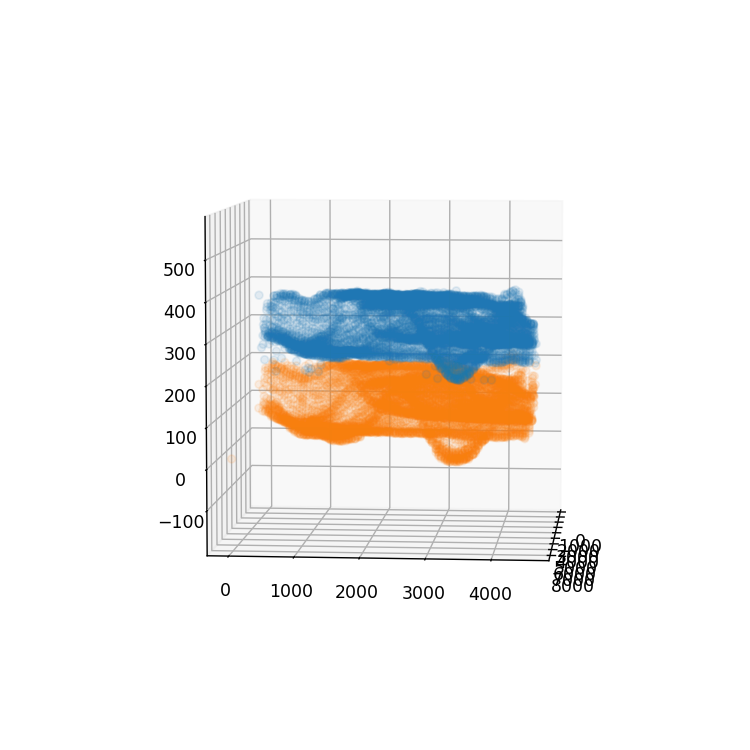

(-192.0, 587.0)

In [35]:
# Top slab
surf_dir = bdir(name_prefix+'_downsampled_thinsurface_bottom.zarr') # thin surface zarr
save_path = surf_dir[:-5]+'_endpts.npy'
surf_dir_2 = bdir(name_prefix+'_downsampled_thinsurface_top.zarr')
save_path_2 = surf_dir_2[:-5]+'_endpts.npy'
grid_size = (100,100) # how many points to sample on surface 
downsample_factor = (20,20,1)


####

surf_pts = sample_surface(surf_dir, grid_size, save_path=save_path)
surf_pts_2 = sample_surface(surf_dir_2, grid_size, save_path=save_path_2)

# Visualize 
#Plot these coordinates in real space 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(surf_pts[:,0]*downsample_factor[0],surf_pts[:,1]*downsample_factor[1],
           surf_pts[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.scatter(surf_pts_2[:,0]*downsample_factor[0],surf_pts_2[:,1]*downsample_factor[1],
           surf_pts_2[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.set_zlim3d(np.minimum(surf_pts[:,2].min()-200, surf_pts_2[:,2].min()-200),
              np.maximum(surf_pts[:,2].max()+200, surf_pts_2[:,2].max()+200))


<IPython.core.display.Javascript object>


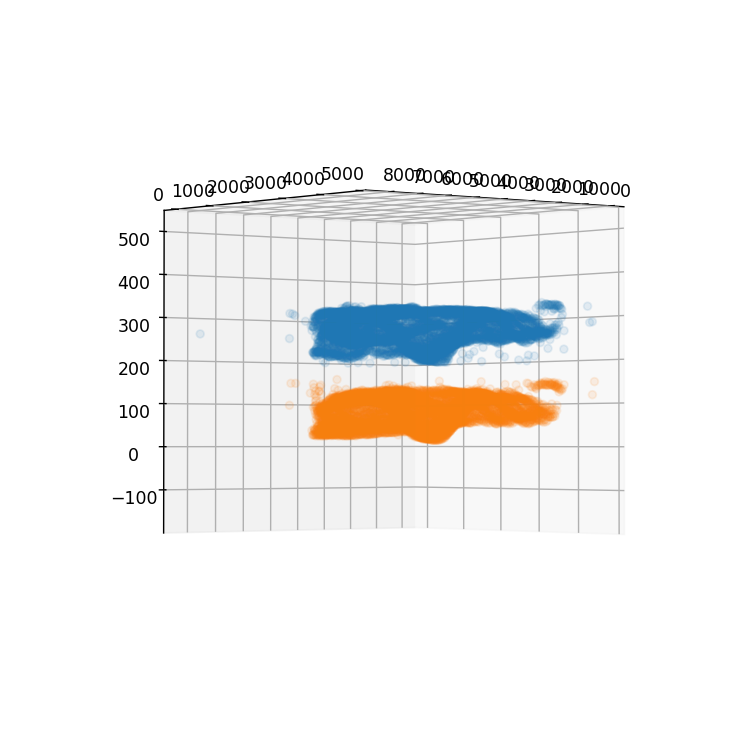

(-185.0, 534.0)

In [36]:
# Bottom slab
surf_dir = bdir(name_prefix2+'_downsampled_thinsurface_bottom.zarr')
save_path = surf_dir[:-5]+'_endpts.npy'
surf_dir_2 = bdir(name_prefix2+'_downsampled_thinsurface_top.zarr')
save_path_2 = surf_dir_2[:-5]+'_endpts.npy'
grid_size = (100,100) # how many points to sample on surface 
downsample_factor = (20,20,1)


####

surf_pts = sample_surface(surf_dir, grid_size, save_path=save_path)
surf_pts_2 = sample_surface(surf_dir_2, grid_size, save_path=save_path_2)

# Visualize 
#Plot these coordinates in real space 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(surf_pts[:,0]*downsample_factor[0],surf_pts[:,1]*downsample_factor[1],
           surf_pts[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.scatter(surf_pts_2[:,0]*downsample_factor[0],surf_pts_2[:,1]*downsample_factor[1],
           surf_pts_2[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.set_zlim3d(np.minimum(surf_pts[:,2].min()-200, surf_pts_2[:,2].min()-200),
              np.maximum(surf_pts[:,2].max()+200, surf_pts_2[:,2].max()+200))


## Outlier removal 

0. Outlier removal based on the manual anchor point detection <br>
1. Gradient outlier removal<br>
2. Statistical outlier removal<br>
3. Manual outlier removal <br>

[Return to top](#top)

<a id='outlier_surf'></a>

### Top slab, top surface


0it [00:00, ?it/s]
367it [00:00, 3669.85it/s]
747it [00:00, 3706.99it/s]
1128it [00:00, 3736.85it/s]
1513it [00:00, 3769.60it/s]
1893it [00:00, 3776.45it/s]
2281it [00:00, 3805.86it/s]
2664it [00:00, 3810.28it/s]
3027it [00:00, 3753.59it/s]
3403it [00:00, 3754.88it/s]
3782it [00:01, 3762.93it/s]
4161it [00:01, 3768.45it/s]
4535it [00:01, 3757.14it/s]
4906it [00:01, 3687.72it/s]
5286it [00:01, 3720.49it/s]
5587it [00:01, 3759.00it/s]

<IPython.core.display.Javascript object>


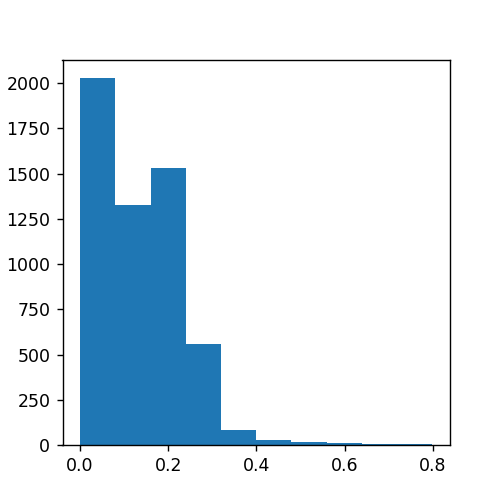

<IPython.core.display.Javascript object>


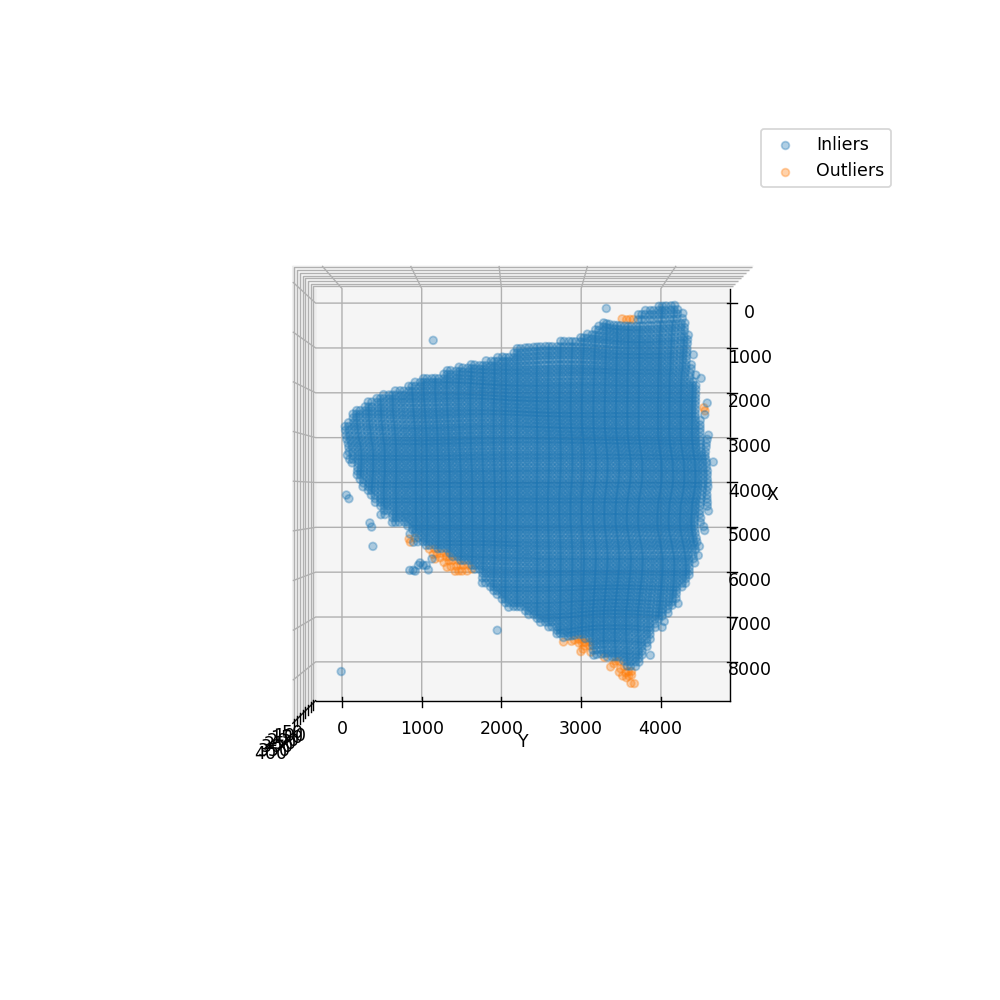

In [50]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts.npy')
eps_save_path = None
num_nns = 20 # number of nearest neighbors to use for gradient estimation
threshold = 0.4 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (20,20,1)

#############################
eps_new = np.load(eps_path)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 9.086016388781404
Mean: 10.274049257515392
Number of inliers: 5136


<IPython.core.display.Javascript object>


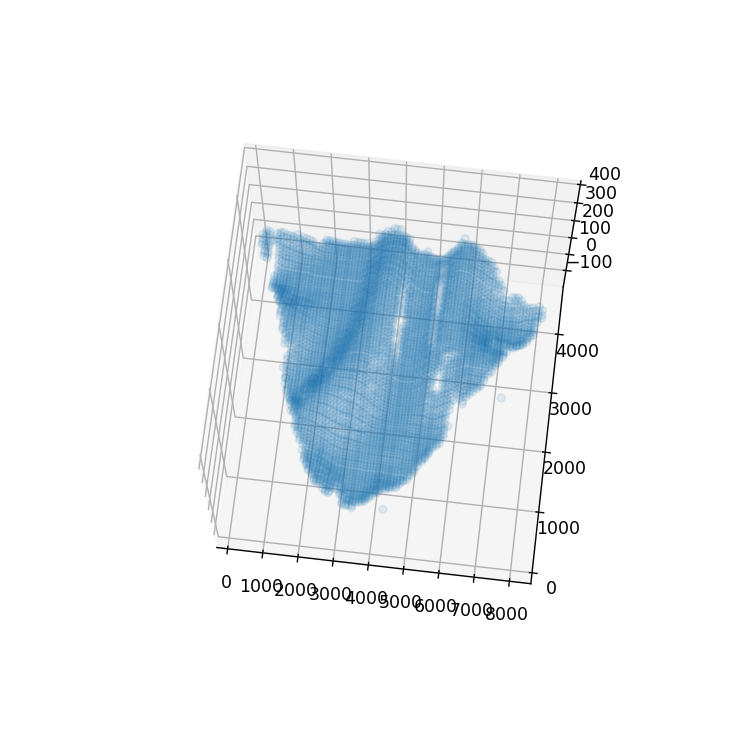

In [52]:
# Statistical outlier removal
do_outlier_removal = True
nn = 20
std_dev_threshold = 1.0
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_outlier.npy')

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)

    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=0.1)
    ax.set_zlim3d(newpts[:,2].min()-200,newpts[:,2].max()+200)
    
    if save_path is not None:
        np.save(save_path, newpts)

### Top slab, bottom surface


0it [00:00, ?it/s]
382it [00:00, 3814.07it/s]
757it [00:00, 3791.90it/s]
1136it [00:00, 3789.70it/s]
1515it [00:00, 3788.95it/s]
1850it [00:00, 3644.45it/s]
2228it [00:00, 3682.94it/s]
2608it [00:00, 3717.25it/s]
2987it [00:00, 3737.76it/s]
3365it [00:00, 3748.29it/s]
3745it [00:01, 3762.33it/s]
4125it [00:01, 3771.34it/s]
4504it [00:01, 3775.99it/s]
4883it [00:01, 3778.74it/s]
5262it [00:01, 3779.88it/s]
5628it [00:01, 3745.90it/s]

<IPython.core.display.Javascript object>


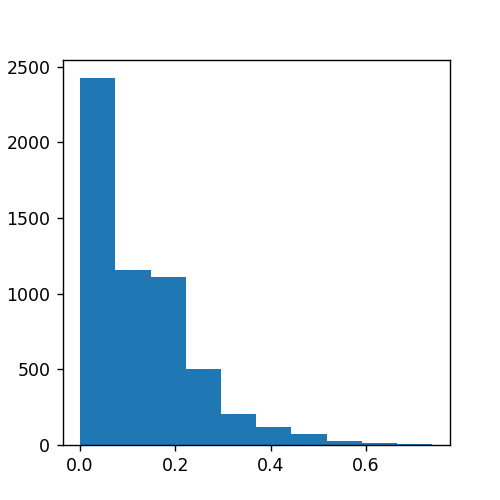

<IPython.core.display.Javascript object>


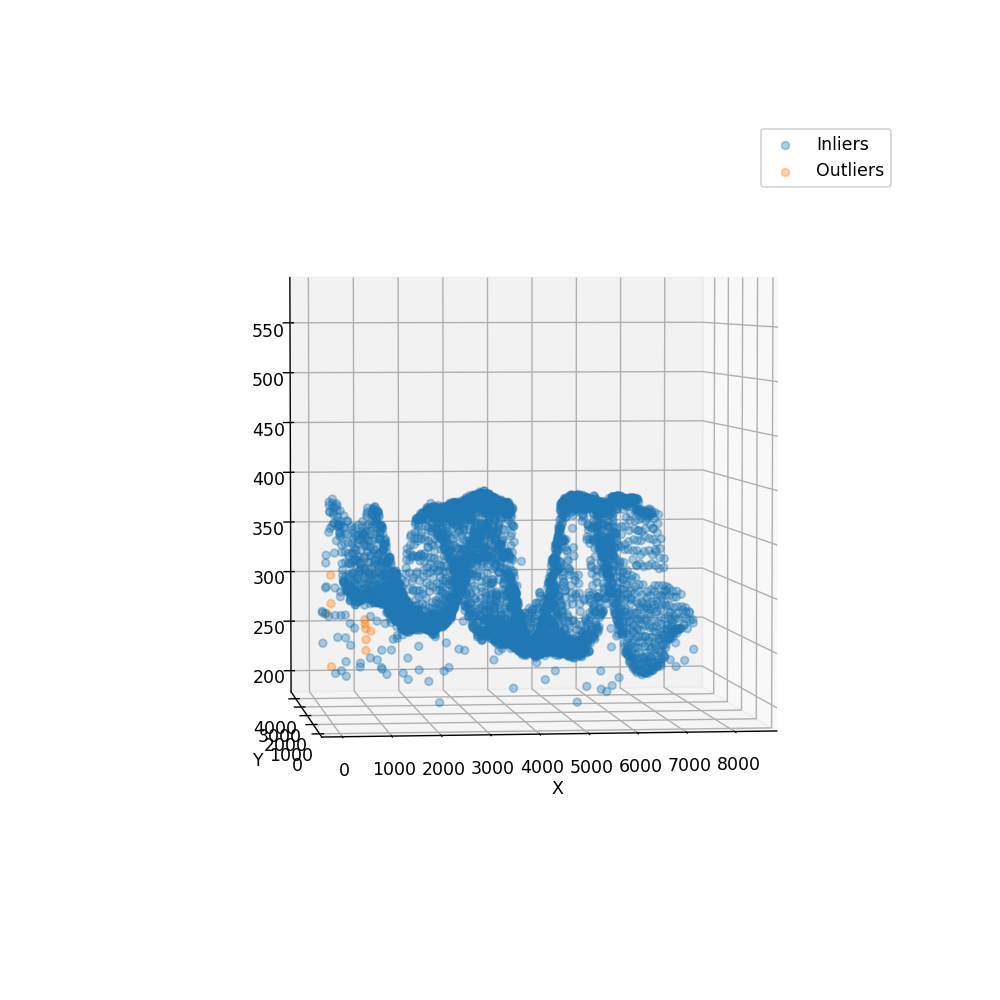

In [45]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts.npy')
eps_save_path = None
num_nns = 20 # number of nearest neighbors to use for gradient estimation
threshold = 0.6 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (20,20,1)

#############################
eps_new = np.load(eps_path)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 11.33638302325882
Mean: 10.724750623441397
Number of inliers: 5093


<IPython.core.display.Javascript object>


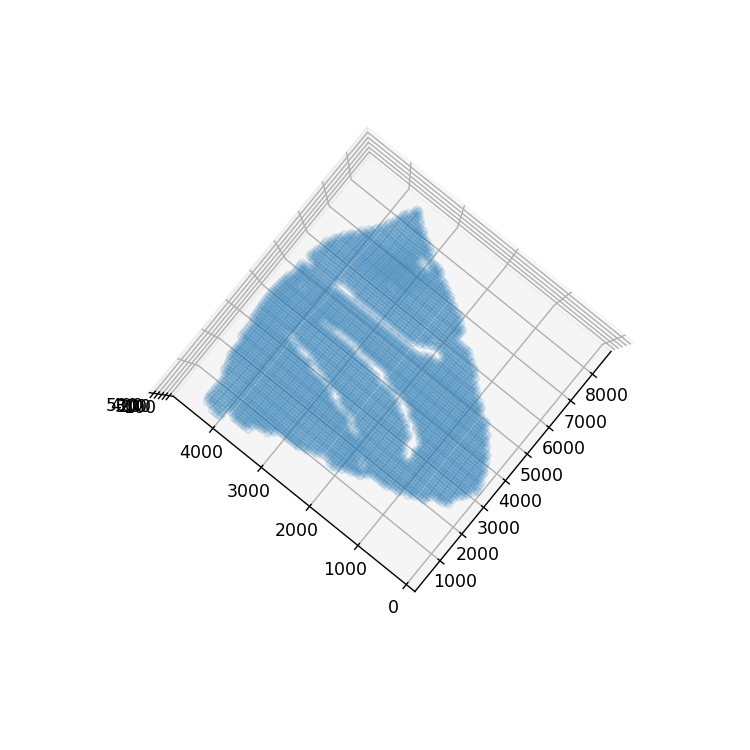

In [49]:
# Statistical outlier removal
do_outlier_removal = True
nn = 20
std_dev_threshold = 1.0
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_outlier.npy') 

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)

    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=0.1)
    ax.set_zlim3d(newpts[:,2].min()-200,newpts[:,2].max()+200)
    
    if save_path is not None:
        np.save(save_path, newpts)

### Bottom slab, top surface


0it [00:00, ?it/s]
386it [00:00, 3856.92it/s]
767it [00:00, 3839.99it/s]
1146it [00:00, 3822.76it/s]
1525it [00:00, 3810.34it/s]
1901it [00:00, 3794.31it/s]
2279it [00:00, 3787.38it/s]
2659it [00:00, 3790.02it/s]
3034it [00:00, 3775.76it/s]
3409it [00:00, 3767.33it/s]
3785it [00:01, 3763.79it/s]
4160it [00:01, 3758.72it/s]
4539it [00:01, 3765.20it/s]
4913it [00:01, 3757.51it/s]
5289it [00:01, 3756.63it/s]
5574it [00:01, 3766.18it/s]

<IPython.core.display.Javascript object>


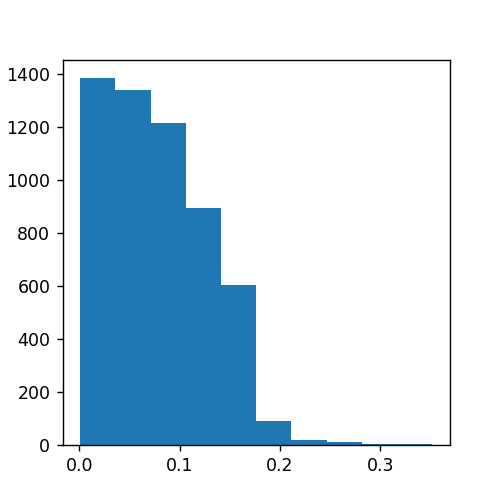

<IPython.core.display.Javascript object>


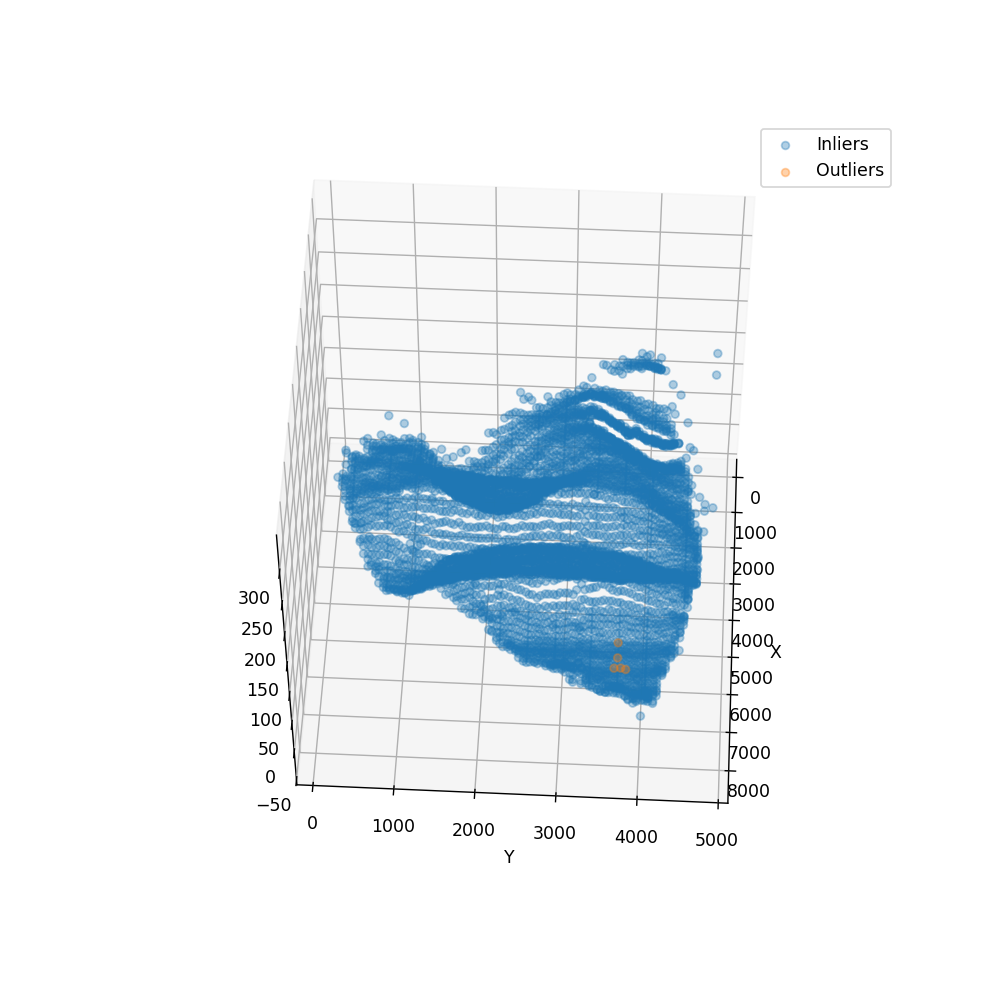

In [55]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts.npy')
eps_save_path = None
num_nns = 20 # number of nearest neighbors to use for gradient estimation
threshold = 0.3 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (20,20,1)

#############################
eps_new = np.load(eps_path)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 6.148085074240197
Mean: 6.980804453223201
Number of inliers: 5438


<IPython.core.display.Javascript object>


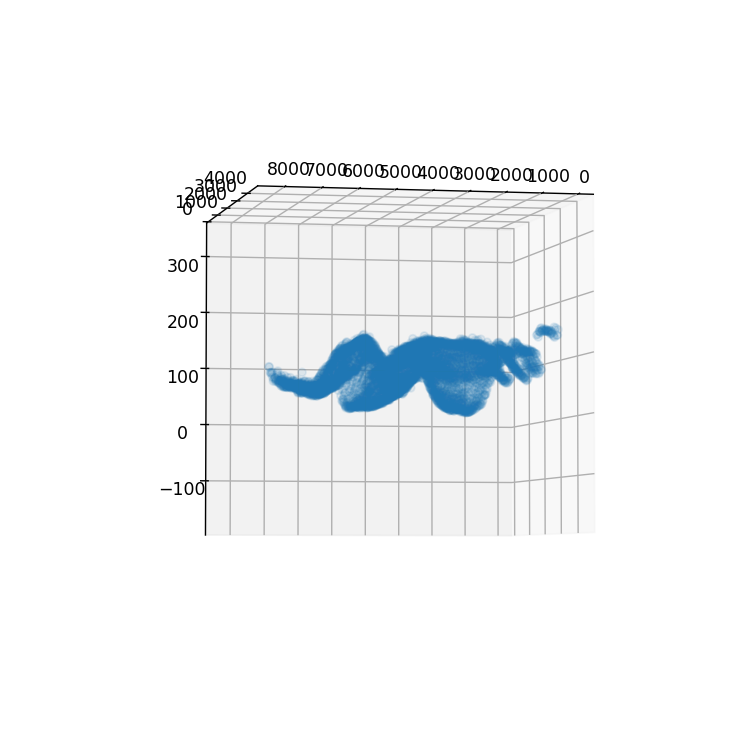

In [56]:
# Statistical outlier removal
do_outlier_removal = True
nn = 20
std_dev_threshold = 1.5
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_outlier.npy')

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)

    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=0.1)
    ax.set_zlim3d(newpts[:,2].min()-200,newpts[:,2].max()+200)
    
    if save_path is not None:
        np.save(save_path, newpts)

### Bottom slab, bottom surface


0it [00:00, ?it/s]
381it [00:00, 3807.90it/s]
742it [00:00, 3744.84it/s]
1118it [00:00, 3748.82it/s]
1450it [00:00, 3606.89it/s]
1820it [00:00, 3632.75it/s]
2195it [00:00, 3664.98it/s]
2546it [00:00, 3615.03it/s]
2925it [00:00, 3665.43it/s]
3296it [00:00, 3677.12it/s]
3674it [00:01, 3705.02it/s]
4053it [00:01, 3728.55it/s]
4431it [00:01, 3741.64it/s]
4801it [00:01, 3592.06it/s]
5183it [00:01, 3657.18it/s]
5548it [00:01, 3673.02it/s]

<IPython.core.display.Javascript object>


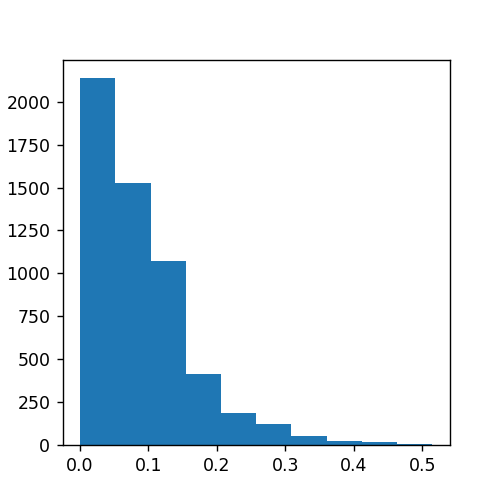

<IPython.core.display.Javascript object>


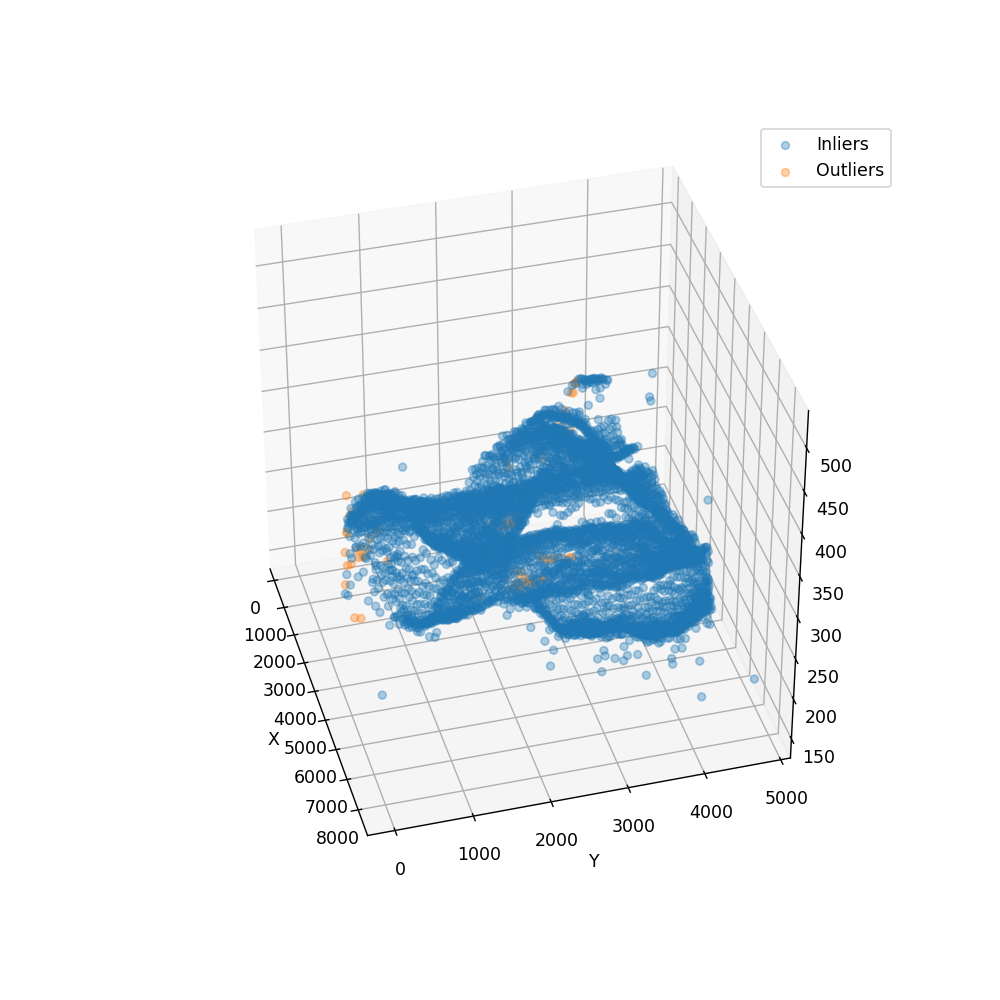

In [57]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts.npy')
eps_save_path = None
num_nns = 20 # number of nearest neighbors to use for gradient estimation
threshold = 0.3 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (20,20,1)

#############################
eps_new = np.load(eps_path)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 6.890664064116331
Mean: 7.482177671510024
Number of inliers: 5197


<IPython.core.display.Javascript object>


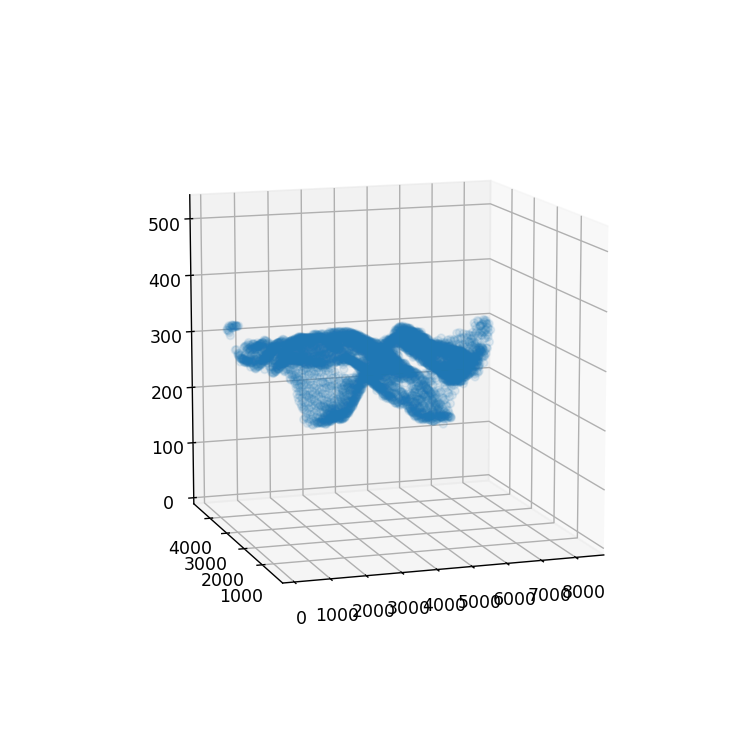

In [58]:
# Statistical outlier removal
do_outlier_removal = True
nn = 20
std_dev_threshold = 1.5
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier.npy') 

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)

    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=0.1)
    ax.set_zlim3d(newpts[:,2].min()-200,newpts[:,2].max()+200)
    
    if save_path is not None:
        np.save(save_path, newpts)

## UV map surfaces

[Return to top](#top)

<a id='uvmap'></a>

In [59]:
# Top slab

# Top surface 
surf_eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_outlier.npy')
surf_eps_uv_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_outlier_uv.npy')
zcoord = None # the z coordinate at which we want the UV map to reside. If none, then will self calculate

# Bottom surface
surf_eps_path2 = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_outlier.npy')
surf_eps_uv_path2 = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_outlier_uv.npy')
zcoord2 = None 

plot = False 

####################################
eps_uv = flatten(surf_eps_path, surf_eps_uv_path, zcoord=zcoord, plot=plot)
eps_uv2 = flatten(surf_eps_path2, surf_eps_uv_path2, zcoord=zcoord2, plot=plot)

In [60]:
# Bottom slab

# Top surface 
surf_eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_outlier.npy')
surf_eps_uv_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_outlier_uv.npy')
zcoord = None # the z coordinate at which we want the UV map to reside. If none, then will self calculate

# Bottom surface
surf_eps_path2 = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier.npy')
surf_eps_uv_path2 = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv.npy')
zcoord2 = None 

plot = False 

####################################
eps_uv = flatten(surf_eps_path, surf_eps_uv_path, zcoord=zcoord, plot=plot)
eps_uv2 = flatten(surf_eps_path2, surf_eps_uv_path2, zcoord=zcoord2, plot=plot)

## Align the UV maps rigidly to image  

[Return to top](#top)

<a id='uvuvalign'></a>

### Top slab

In [61]:
# old flattened and non-flattened paths
top_eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_outlier.npy')
top_eps_uv_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_outlier_uv.npy')
bot_eps_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_outlier.npy')
bot_eps_uv_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_outlier_uv.npy')

# new flattened and non-flattened paths, after filtering, UV-UV aligning, and surface-UV aligning 
top_eps_path2 = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_outlier_new.npy')
top_eps_uv_path2 = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_outlier_uv_new.npy')
bot_eps_path2 = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_outlier_new.npy')
bot_eps_uv_path2 = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')


Mean thickness: 196.33113317757008
Low threshold thickness: 172.1542787591871
High threshold thickness: 220.50798759595307
Mean thickness: 196.77808757117614
Low threshold thickness: 173.6493094656943
High threshold thickness: 219.906865676658
New mean thickness: 194.4094622331691


<IPython.core.display.Javascript object>


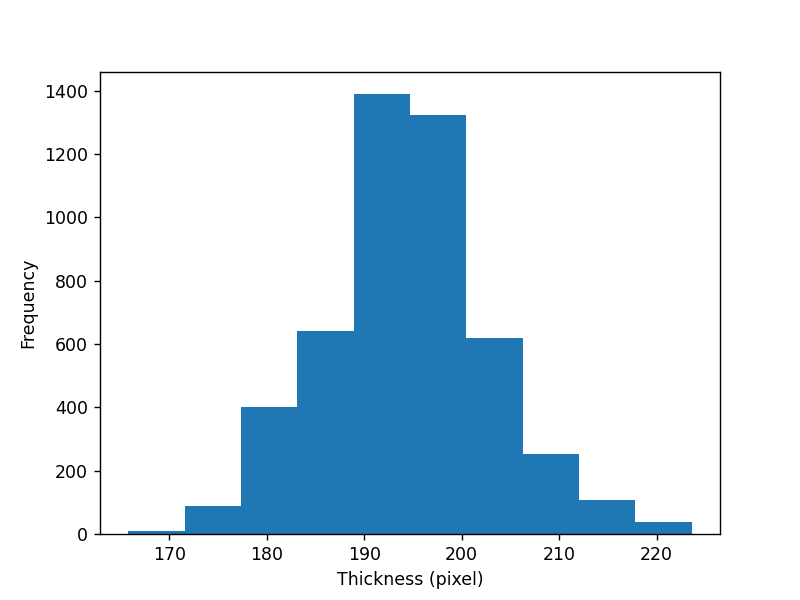

<IPython.core.display.Javascript object>


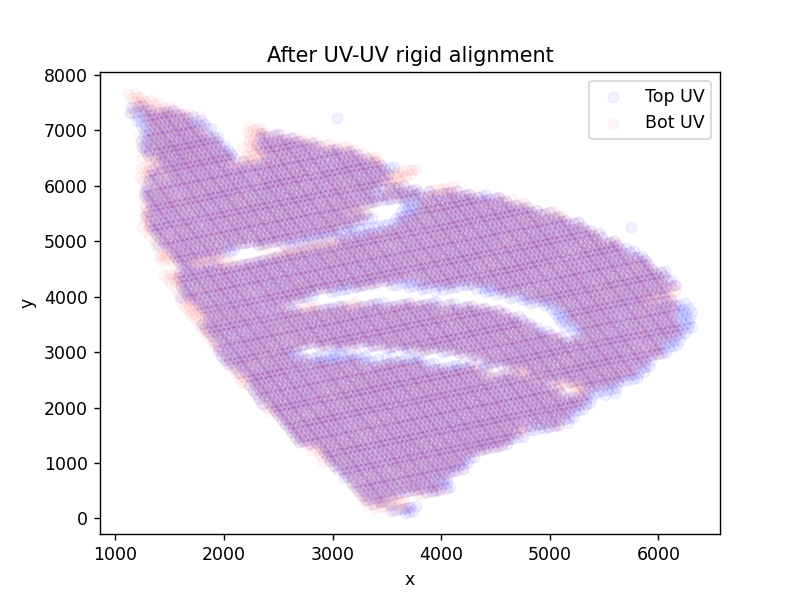

<IPython.core.display.Javascript object>


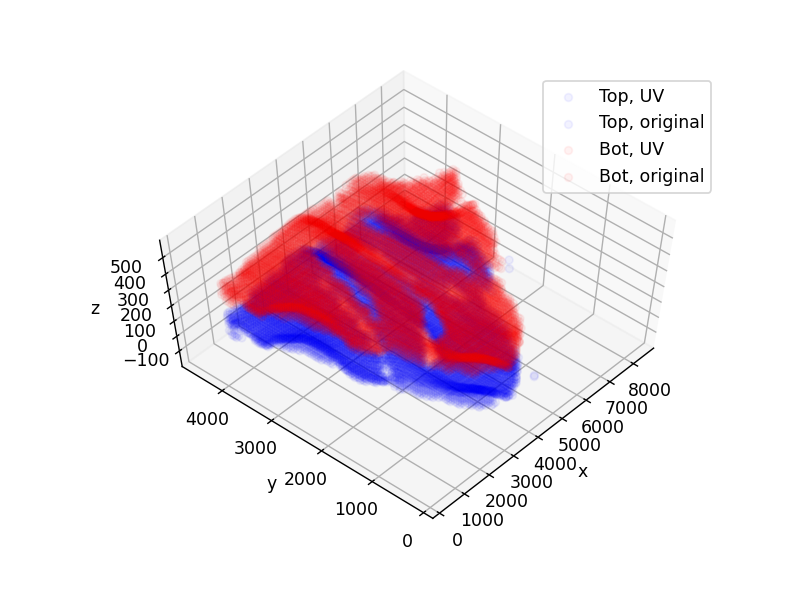

Number of top surface points:4872
Number of bottom surface points:4842


In [62]:
# Params 
thickness_filter = True
nns = 10
n_std = 2 # num std. devs away from mean thickness to remove
plot = True 


#############
bot_eps = np.load(bot_eps_path)
bot_eps_uv = np.load(bot_eps_uv_path)
top_eps = np.load(top_eps_path)
top_eps_uv = np.load(top_eps_uv_path)

top_eps_flat, top_eps_uv, bot_eps_flat, bot_eps_uv = align_uv_maps(top_eps, top_eps_uv, bot_eps, bot_eps_uv,
                                                                   thickness_filter=thickness_filter, nns=nns, n_std=n_std, plot=plot)

np.save(bot_eps_path2, bot_eps_flat)
np.save(bot_eps_uv_path2, bot_eps_uv)
np.save(top_eps_path2, top_eps_flat)
np.save(top_eps_uv_path2, top_eps_uv)

print("Number of top surface points:%d"%top_eps_flat.shape[0])
print("Number of bottom surface points:%d"%bot_eps_flat.shape[0])

### Bottom slab

In [63]:
# old flattened and non-flattened paths
top_eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_outlier.npy')
top_eps_uv_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_outlier_uv.npy')
bot_eps_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier.npy')
bot_eps_uv_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv.npy')

# new flattened and non-flattened paths, after filtering, UV-UV aligning, and surface-UV aligning 
top_eps_path2 = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_outlier_new.npy')
top_eps_uv_path2 = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_outlier_uv_new.npy')
bot_eps_path2 = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_new.npy')
bot_eps_uv_path2 = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')


Mean thickness: 192.3216255976462
Mean thickness: 192.2569751779873
New mean thickness: 192.3216255976462


<IPython.core.display.Javascript object>


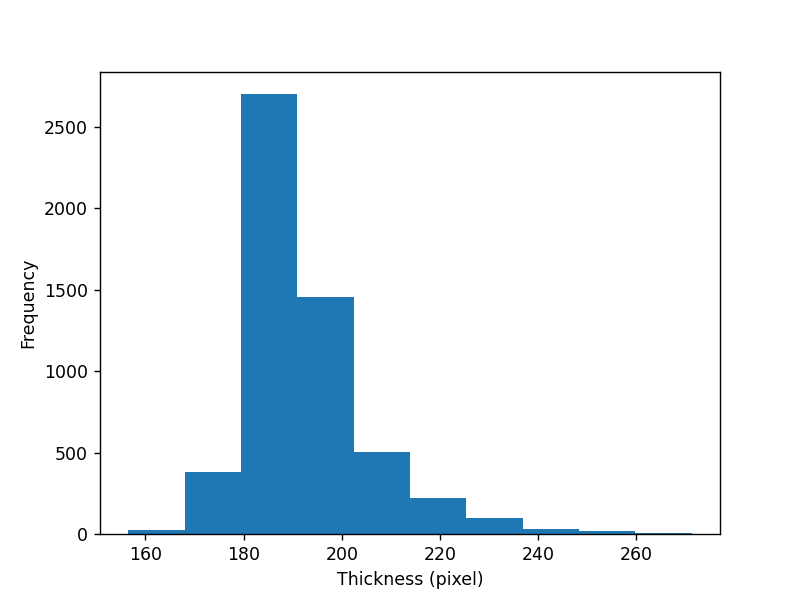

<IPython.core.display.Javascript object>


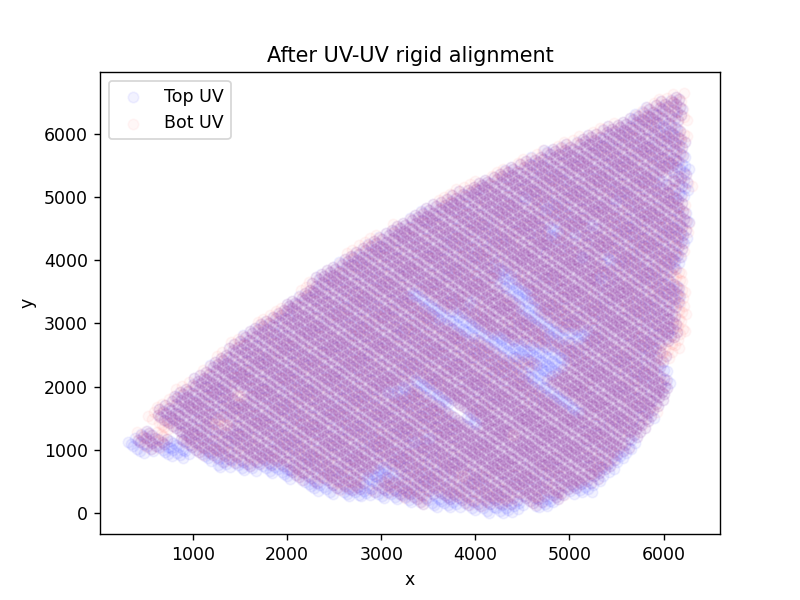

<IPython.core.display.Javascript object>


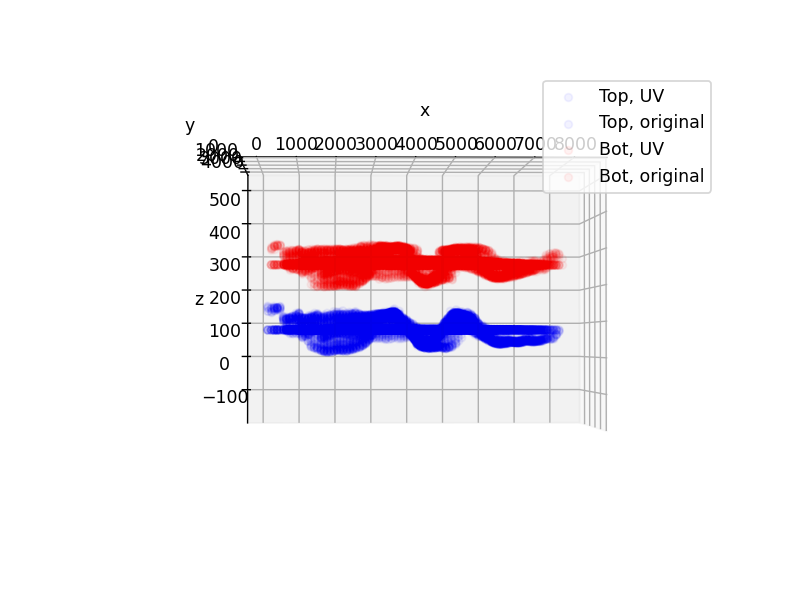

Number of top surface points:5438
Number of bottom surface points:5197


In [64]:
# Params 
thickness_filter = False
nns = 10
n_std = 2 # num std. devs away from mean thickness to remove
plot = True 


#############
bot_eps = np.load(bot_eps_path)
bot_eps_uv = np.load(bot_eps_uv_path)
top_eps = np.load(top_eps_path)
top_eps_uv = np.load(top_eps_uv_path)

top_eps_flat, top_eps_uv, bot_eps_flat, bot_eps_uv = align_uv_maps(top_eps, top_eps_uv, bot_eps, bot_eps_uv,
                                                                   thickness_filter=thickness_filter, nns=nns, n_std=n_std, plot=plot)

np.save(bot_eps_path2, bot_eps_flat)
np.save(bot_eps_uv_path2, bot_eps_uv)
np.save(top_eps_path2, top_eps_flat)
np.save(top_eps_uv_path2, top_eps_uv)

print("Number of top surface points:%d"%top_eps_flat.shape[0])
print("Number of bottom surface points:%d"%bot_eps_flat.shape[0])

## (Optional) Flatten warp the slabs

[Return to top](#top)

<a id='flattenwarp'></a>

In [74]:
# Top slab 
top_eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_outlier_new.npy')
top_eps_uv_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_outlier_uv_new.npy')
bot_eps_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_outlier_new.npy')
bot_eps_uv_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')

# Parameters for TPS zarr warp
moving_zarr_path = bdir(name_prefix+'.zarr')
warped_zarr_path = bdir(name_prefix+'_flattened.zarr')
grid_spacing = 3*(32,)
chunks=3*(200,)
save_grid_values_path = bdir(name_prefix+'_grid_flatten.npy')
use_grid_values_path = None



######################################
bot_eps = np.load(bot_eps_path)
bot_eps_uv = np.load(bot_eps_uv_path)
top_eps = np.load(top_eps_path)
top_eps_uv = np.load(top_eps_uv_path)

# combine these
fixed_pts = np.concatenate((bot_eps_uv,top_eps_uv),axis=0)
moving_pts = np.concatenate((bot_eps,top_eps),axis=0)

TPS_zarr_warp(moving_zarr_path, warped_zarr_path,
                  moving_pts, fixed_pts,
                  grid_spacing=grid_spacing, smooth=2,
                  Rinv=None, binv=None, chunks=chunks,
                  nb_workers=8, padding=2,
                  save_grid_values_path=save_grid_values_path, show_residuals=True,
                 use_grid_values_path=use_grid_values_path)

Fitting radial basis function...
Fitting rbf took 392.936758 seconds
Nonrigid ave. distance [pixels]: 0.0013217259361627605
Warping grid...
Warping grid took 572.284232 seconds
Saved grid_values at /mnt/beegfs/webster/fig3_dfly/#3-lec_grid_flatten.npy
Warping image...



 42%|████▏     | 874/2064 [02:03<02:40,  7.43it/s]


 79%|███████▉  | 1636/2064 [04:09<01:26,  4.94it/s]


100%|██████████| 2064/2064 [05:26<00:00,  6.33it/s]

Time elapsed: 33.489183 minutes


<zarr.core.Array (8456, 4648, 400) uint16>

In [77]:
# Convert zarr to tiff
warped_zarr_path = bdir(name_prefix+'_flattened.zarr')
tiff_path = warped_zarr_path[:-5]+'tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Loading z 0 - 200



100%|██████████| 200/200 [05:34<00:00,  1.77s/it]


Loading z 200 - 400



100%|██████████| 200/200 [05:02<00:00,  1.46s/it]


In [75]:
# Bottom slab 
top_eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_outlier_new.npy')
top_eps_uv_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_outlier_uv_new.npy')
bot_eps_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_new.npy')
bot_eps_uv_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')

# Parameters for TPS zarr warp
moving_zarr_path = bdir(name_prefix2+'.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened.zarr')
grid_spacing = 3*(64,)
chunks=3*(200,)
save_grid_values_path = bdir(name_prefix2+'_grid_flatten.npy')
use_grid_values_path = None



######################################
bot_eps = np.load(bot_eps_path)
bot_eps_uv = np.load(bot_eps_uv_path)
top_eps = np.load(top_eps_path)
top_eps_uv = np.load(top_eps_uv_path)

# combine these
fixed_pts = np.concatenate((bot_eps_uv,top_eps_uv),axis=0)
moving_pts = np.concatenate((bot_eps,top_eps),axis=0)

TPS_zarr_warp(moving_zarr_path, warped_zarr_path,
                  moving_pts, fixed_pts,
                  grid_spacing=grid_spacing, smooth=2,
                  Rinv=None, binv=None, chunks=chunks,
                  nb_workers=8, padding=2,
                  save_grid_values_path=save_grid_values_path, show_residuals=True,
                 use_grid_values_path=use_grid_values_path)

Fitting radial basis function...
Fitting rbf took 546.194243 seconds
Nonrigid ave. distance [pixels]: 0.0014866690776143964
Warping grid...
Warping grid took 59.629889 seconds
Saved grid_values at /mnt/beegfs/webster/fig3_dfly/#4-lec_grid_flatten.npy
Warping image...



 39%|███▊      | 813/2100 [01:38<04:15,  5.04it/s]


 77%|███████▋  | 1612/2100 [03:45<01:24,  5.76it/s]


100%|██████████| 2100/2100 [05:14<00:00,  6.67it/s]

Time elapsed: 25.460949 minutes


<zarr.core.Array (8400, 4816, 341) uint16>

In [76]:
# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Loading z 0 - 200



100%|██████████| 200/200 [07:52<00:00,  2.25s/it]


Loading z 200 - 341



100%|██████████| 141/141 [04:55<00:00,  1.87s/it]


## Points flatten warp (manual anchor points + detected endpoints)

Transform detected endpoints and anchor points into flattened reference frame <br>

[Return to top](#top)

<a id='pointflatten'>

In [52]:
# Top, bottom surface 

# Manual anchor points, these need to be loaded and added to pts_transform_paths list
arteries_numpy_save_path = bdir(name_prefix+'_anchor_pts.npy')
arteries_flattened_save_path = bdir(name_prefix+'_anchor_pts_flat.npy') # path to save the flattened transformed anchors

arteries_path = bdir('3R1_annotations.json')
annotation_name = 'anchor_points'
resample_factor = (0.28,0.28,1) # multiply this by the anchor points to get to correct reference frame 
offset = (0,1700,14) # subtract these to get the actual reference frame 

moving_pts_paths = [bdir(name_prefix+'_downsampled_thinsurface_top_endpts_outlier_new.npy'), #top surface
                   bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_outlier_new.npy')] # bottom surface
fixed_pts_paths = [bdir(name_prefix+'_downsampled_thinsurface_top_endpts_outlier_uv_new.npy'), #top flat surface
                   bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')] #bottom flat surface
pts_transform_paths = [bdir(name_prefix+'_endpoints_bottom_masked.npy'), # detected eps
                      arteries_numpy_save_path ] # anchor points
pts_transform_save_paths = [bdir(name_prefix+'_endpoints_bottom_masked_flat.npy'),
                           arteries_flattened_save_path] # path to save the transformed points





##############################
# Load manual anchor points 
if arteries_path[-3:] == 'csv':
    arteries = np.asarray(pd.read_csv(arteries_path))
    flattened_arteries = arteries[:,:3]   
elif arteries_path[-4:] == 'json':
    flattened_arteries = read_annotations_json(arteries_path, annotation_name, sink_path=None)
flattened_arteries[:,0] -= offset[0]; flattened_arteries[:,1] -= offset[1]; flattened_arteries[:,2] -= offset[2]
flattened_arteries = flattened_arteries.astype('float')
flattened_arteries[:,0] *= resample_factor[0]; flattened_arteries[:,1] *= resample_factor[1]; flattened_arteries[:,2] *= resample_factor[2]
flattened_arteries = np.round(flattened_arteries).astype('int')
np.save(arteries_numpy_save_path, flattened_arteries)

# TPS transform    
_ = TPS_transform_points(moving_pts_paths, fixed_pts_paths, pts_masked_paths=pts_transform_paths, 
                     pts_masked_save_paths=pts_transform_save_paths, static_pts_paths=None, 
                    R_path=None, b_path=None)

Fitting radial basis function...
Fitting rbf took 381.710039 seconds


In [53]:
# Bottom, top surface 

# Manual anchor points, these need to be loaded and added to pts_transform_paths list
arteries_numpy_save_path = bdir(name_prefix2+'_anchor_pts.npy')
arteries_flattened_save_path = bdir(name_prefix2+'_anchor_pts_flat.npy') # path to save the flattened transformed anchors

arteries_path = bdir('4R1_annotations.json')
annotation_name = 'anchor_points'
resample_factor = (0.28,0.28,1) # multiply this by the anchor points to get to correct reference frame 
offset = (0,1482,0) # subtract these to get the actual reference frame 


moving_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_outlier_new.npy'), #top surface
                   bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_new.npy')] # bottom surface
fixed_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_outlier_uv_new.npy'), #top flat surface
                   bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')] #bottom flat surface
pts_transform_paths = [bdir(name_prefix2+'_endpoints_top_masked.npy'), # detected eps
                      arteries_numpy_save_path ] # anchor points
pts_transform_save_paths = [bdir(name_prefix2+'_endpoints_top_masked_flat.npy'),
                           arteries_flattened_save_path] # path to save the transformed points

##############################
# Load manual anchor points 
if arteries_path[-3:] == 'csv':
    arteries = np.asarray(pd.read_csv(arteries_path))
    flattened_arteries = arteries[:,3:]   
elif arteries_path[-4:] == 'json':
    flattened_arteries = read_annotations_json(arteries_path, annotation_name, sink_path=None)
flattened_arteries[:,0] -= offset[0]; flattened_arteries[:,1] -= offset[1]; flattened_arteries[:,2] -= offset[2]
flattened_arteries = flattened_arteries.astype('float')
flattened_arteries[:,0] *= resample_factor[0]; flattened_arteries[:,1] *= resample_factor[1]; flattened_arteries[:,2] *= resample_factor[2]
flattened_arteries = np.round(flattened_arteries).astype('int')
np.save(arteries_numpy_save_path, flattened_arteries)

# TPS transform    
_ = TPS_transform_points(moving_pts_paths, fixed_pts_paths, pts_masked_paths=pts_transform_paths, 
                     pts_masked_save_paths=pts_transform_save_paths, static_pts_paths=None, 
                    R_path=None, b_path=None)

Fitting radial basis function...
Fitting rbf took 549.460501 seconds


## Rigid alignment (using manual anchor points)

[Return to top](#top)

<a id='rigidanchor'></a>

215.23860529473487


<IPython.core.display.Javascript object>


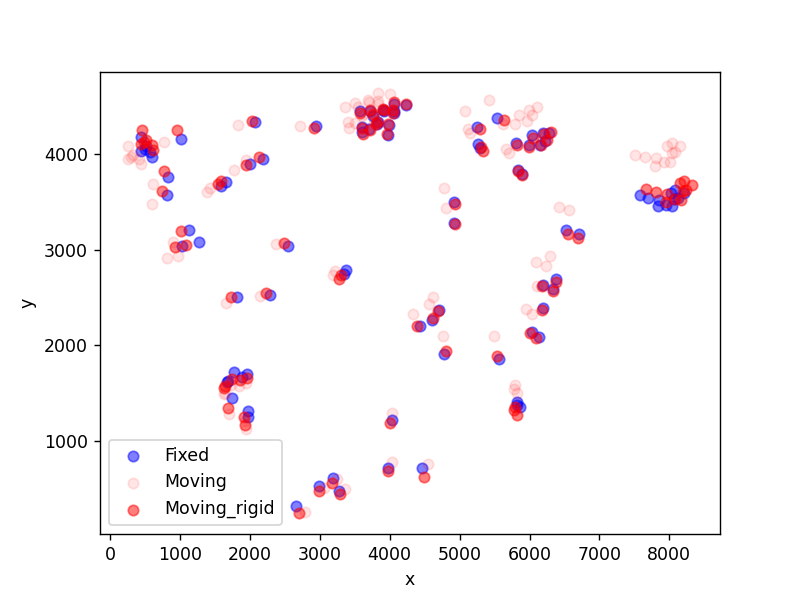

In [3]:
flattened_arteries_path = bdir(name_prefix+'_anchor_pts_flat.npy') # top slab, bottom side
flattened_arteries_path2 = bdir(name_prefix2+'_anchor_pts_flat.npy') # bottom slab, top side 
plot2d = True # if False, plot points in 3d
use2d = True # don't use 3d, the nonplanar rotation is too sensitive to the endpoint detection


###############################################
flattened_arteries = np.load(flattened_arteries_path)
flattened_arteries_2 = np.load(flattened_arteries_path2)

# if doing 2d
if use2d:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2[:,:2]), np.transpose(flattened_arteries[:,:2]))
    new_pts = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2[:,:2])) + b)
    new_points = np.concatenate((new_pts,flattened_arteries_2[:,2:3]),axis=1) # add in the z coordinate
    
    # needs to be 3x3 for future transforms
    Rn = np.zeros((3,3))
    Rn[:2,:2] = R
    Rn[2,2] = 1
    bn = np.zeros((3,))
    bn[:2] = b[:,0]
    
    # compute the approximate z translation 
    zadd = np.mean(flattened_arteries[:,2] - flattened_arteries_2[:,2])
    bn[2] = zadd 
    print(zadd)
    R = Rn
    b = bn
    
# 3d
else:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2), np.transpose(flattened_arteries))
    new_points = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2)) + b)
    print(b)
    # we don't want to screw with the z coordinate translation
    b[2] = 0

np.save(bdir('R.npy'), R)
np.save(bdir('b.npy'), b.squeeze())

# 2D
fig = plt.figure()

if plot2d:
    ax = fig.add_subplot(1,1,1)#,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1, color='r')
    ax.scatter(new_points[:,0],new_points[:,1],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])

#3d
else:
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],flattened_arteries[:,2],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1,color='r')
    ax.scatter(new_points[:,0],new_points[:,1],new_points[:,2],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])

## TPS warp based on manual anchor points 

[Return to top](#top)

<a id='anchorwarp'></a>

In [4]:
moving_pts_paths = [bdir(name_prefix2+'_anchor_pts_flat.npy')]
fixed_pts_paths =  [bdir(name_prefix+'_anchor_pts_flat.npy')]

fixed_zarr_path = bdir(name_prefix+'_flattened.zarr')
moving_zarr_path = bdir(name_prefix2+'_flattened.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp.zarr')


# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers = 8 

# affine parameters 
R_path = bdir('R.npy')
b_path = bdir('b.npy')

# grid I/O 
save_grid_values_path = bdir('grid_anchor_tps.npy')
use_grid_values_path = None

# anchor parameters (using the surface on the other side and manually identified anchors on the cut surface)
static_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')]

##########################

TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Fitting radial basis function...
Fitting rbf took 69.669906 seconds
Nonrigid ave. distance [pixels]: 5.6125061939826276e-05
Warping grid...
Warping grid took 377.562663 seconds
Saved grid_values at /mnt/beegfs/webster/fig3_dfly/grid_anchor_tps.npy
Warping image...


100%|██████████| 3096/3096 [07:40<00:00,  6.72it/s]


Time elapsed: 23.413252 minutes
Loading z 0 - 200


100%|██████████| 200/200 [07:43<00:00,  2.59s/it]


Loading z 200 - 400


100%|██████████| 200/200 [07:52<00:00,  2.44s/it]


Loading z 400 - 556


100%|██████████| 156/156 [06:02<00:00,  2.35s/it]


### Warp all of the moving endpoints to the new frame so we can apply TPS

In [54]:
moving_pts_paths = [bdir(name_prefix2+'_anchor_pts_flat.npy')]
fixed_pts_paths =  [bdir(name_prefix+'_anchor_pts_flat.npy')]

pts_transform_paths = [bdir(name_prefix2+'_endpoints_top_masked_flat.npy'), # detected eps
                       bdir(name_prefix2+'_anchor_pts_flat.npy')] # anchor points
pts_transform_save_paths = [bdir(name_prefix2+'_endpoints_top_masked_flat_anchorwarp.npy'),
                           bdir(name_prefix2+'_anchor_pts_flat_anchorwarp.npy')] 

# Other surface points for anchoring the transformation
static_pts_path = [bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')]

# Affine parameters
R_path = bdir('R.npy')
b_path = bdir('b.npy')

##############################
# TPS transform    
_ = TPS_transform_points(moving_pts_paths, fixed_pts_paths, pts_masked_paths=pts_transform_paths, 
                     pts_masked_save_paths=pts_transform_save_paths, static_pts_paths=static_pts_paths, 
                    R_path=R_path, b_path=b_path)

Fitting radial basis function...
Fitting rbf took 71.423321 seconds


In [58]:
a = np.load(bdir(name_prefix2+'_endpoints_top_masked_flat_anchorwarp.npy'))
b = np.load(bdir(name_prefix+'_endpoints_bottom_masked_flat.npy'))
print(a.shape, b.shape)

(1132, 3) (1399, 3)


In [ ]:
# Convert anchor points to json for visualization 
anchor_pts_path = bdir(name_prefix+'_anchor_pts_flat.npy') # this will be the flattened fixed anchor points

#############
anchor_pts = np.load(anchor_pts_path)
numpy_to_json(anchor_pts, anchor_pts_path[:-4]+'.json')

## Feature matching 

[Return to top](#top)

<a id='featmatch'></a>

In [63]:
# I/O 
moving_coords_path = bdir(name_prefix2+'_endpoints_top_masked_flat_anchorwarp.npy')
fixed_coords_path = bdir(name_prefix+'_endpoints_bottom_masked_flat.npy')

moving_coords_matched_path = bdir(name_prefix2+'_endpoints_top_matched.npy')
fixed_coords_matched_path = bdir(name_prefix+'_endpoints_bottom_matched.npy')


# Fixed image zarr
z = zarr.open(bdir(name_prefix+'_flattened.zarr'),mode='r')
fixed_img_size = z.shape

# Feature descriptor parameters 
num_nn = 7
search_radius = 100 
ratio_thresh = 0.9
num_nn_used = 4
return_nn = False
use3d = True 




#######################
moving_coords = np.load(moving_coords_path)
fixed_coords = np.load(fixed_coords_path)

fixed_feats = compute_spatial_descriptor(fixed_coords, num_nn=num_nn)
moving_feats = compute_spatial_descriptor(moving_coords, num_nn=num_nn)

fixed_coords_matched, fixed_feats_matched, moving_coords_matched, moving_feats_matched, a, b = \
                compute_feature_matches(fixed_coords, fixed_feats, moving_coords, moving_feats,
                                       use3d, search_radius, ratio_thresh, num_nn_used, return_nn=return_nn)

np.save(moving_coords_matched_path, moving_coords_matched)
np.save(fixed_coords_matched_path, fixed_coords_matched)

100%|██████████| 1132/1132 [00:07<00:00, 157.96it/s]


In [64]:
print(moving_coords.shape, fixed_coords.shape)
print(moving_coords_matched.shape, fixed_coords_matched.shape)

(1132, 3) (1399, 3)
(328, 3) (328, 3)


### RANSAC

In [65]:
moving_coords_ransac_path = bdir(name_prefix2+'_endpoints_top_matched_ransac.npy')
fixed_coords_ransac_path = bdir(name_prefix+'_endpoints_bottom_matched_ransac.npy')

# RANSAC
error_threshold = 35 # ideal is 35 
use_3d = True 
use_local_ransac = True

opts = {'apply_affine_transform' : False, 
        'min_samples' : 1, # this parameter doesn't actually matter
       'num_x_tiles' : 20,
       'num_y_tiles' : 10,
       'size_image' : fixed_img_size[:2],
       'min_matches' : 3}




#################### Filter outliers with RANSAC
fixed_coords_r, moving_coords_r, fixed_feats_r, moving_feats_r = apply_ransac(fixed_coords_matched, moving_coords_matched, 
                                                                              fixed_feats_matched, moving_feats_matched, 
                                                                    error_threshold, use_3d, use_local_ransac, **opts)

np.save(fixed_coords_ransac_path, fixed_coords_r)
np.save(moving_coords_ransac_path, moving_coords_r)

Not enough matches in in tile (0,0), skipping...
Not enough matches in in tile (0,1), skipping...
Not enough matches in in tile (0,2), skipping...
Not enough matches in in tile (0,3), skipping...
Not enough matches in in tile (0,4), skipping...
Not enough matches in in tile (0,5), skipping...
Not enough matches in in tile (0,6), skipping...
Not enough matches in in tile (0,7), skipping...
Not enough matches in in tile (0,8), skipping...
Not enough matches in in tile (0,9), skipping...
Not enough matches in in tile (1,0), skipping...
Not enough matches in in tile (1,1), skipping...
Not enough matches in in tile (1,2), skipping...
Not enough matches in in tile (1,3), skipping...
Not enough matches in in tile (1,4), skipping...
Not enough matches in in tile (1,5), skipping...
Not enough matches in in tile (1,6), skipping...
Not enough matches in in tile (1,7), skipping...
Number of matches found: 4
Finished filtering tile (1,8)
Not enough matches in in tile (1,9), skipping...
Not enough m

<IPython.core.display.Javascript object>


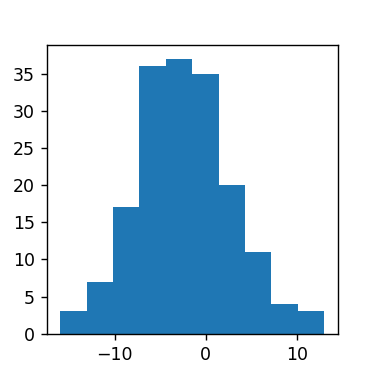

<IPython.core.display.Javascript object>


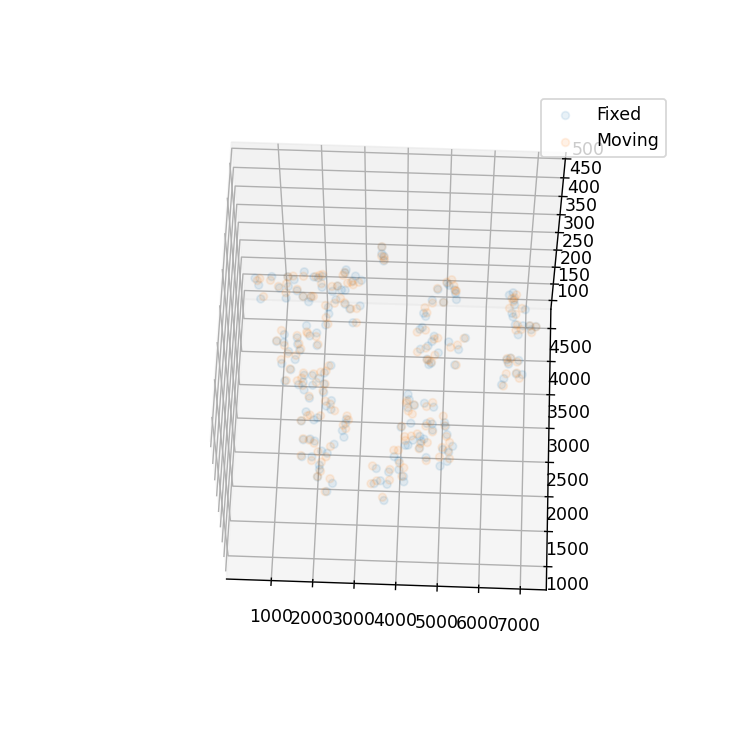

Number of feature matches: 328
Number of RANSAC matches: 173


In [66]:
# Might need to filter out matches that are too far away in z
max_z_difference = 1000


#############
plt.figure(figsize=(3,3))
plt.hist(fixed_coords_r[:,2]-moving_coords_r[:,2])
plt.show()

fixed_new = fixed_coords_r[np.abs(fixed_coords_r[:,2]-moving_coords_r[:,2]) <= max_z_difference]
moving_new = moving_coords_r[np.abs(fixed_coords_r[:,2]-moving_coords_r[:,2]) <=max_z_difference]

#Plot these coordinates
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(fixed_new[:,0],fixed_new[:,1],fixed_new[:,2],antialiased=True, alpha=0.1)
ax.scatter(moving_new[:,0],moving_new[:,1],moving_new[:,2],antialiased=True,alpha=0.1)
ax.set_zlim3d(fixed_coords_r[:,2].min()-200,fixed_coords_r[:,2].max()+200)
ax.legend(['Fixed','Moving'])


print("Number of feature matches:",fixed_coords_matched.shape[0])
print("Number of RANSAC matches:",fixed_new.shape[0])


np.save(fixed_coords_ransac_path, fixed_new)
np.save(moving_coords_ransac_path, moving_new)

In [67]:
# Convert to JSON

detected_eps_match_path = bdir(name_prefix+'_endpoints_bottom_matched_ransac.npy') # fixed endpoints 
moving_eps_match_path = bdir(name_prefix2+'_endpoints_top_matched_ransac.npy')


#######
detected_eps_match = np.load(detected_eps_match_path)
moving_eps_match = np.load(moving_eps_match_path)
numpy_to_json(detected_eps_match, detected_eps_match_path[:-4]+'.json')
numpy_to_json(moving_eps_match, moving_eps_match_path[:-4]+'.json')

## TPS Warp 

[Return to top](#top)

<a id='tpswarp'></a>

In [117]:
# Read in JSON file with newly labelled 

# Load in the new anchor points (combine the old anchor points with the new ones)

json_path = bdir('r0_anchorpts.json')
new_anchor_pts_moving_path = bdir(name_prefix2+'_anchorwarp_anchor_pts.npy')
new_anchor_pts_fixed_path = bdir(name_prefix+'_anchorwarp_anchor_pts.npy')
moving_name = 'points_4'
fixed_name = 'points_3'

##############
moving_pts_new = read_annotations_json(json_path, moving_name, sink_path=new_anchor_pts_moving_path)
fixed_pts_new = read_annotations_json(json_path, fixed_name, sink_path=new_anchor_pts_fixed_path)


# Also save individually in JSON so that we can visualize 
numpy_to_json(fixed_pts_new, new_anchor_pts_fixed_path[:-4]+'.json')
numpy_to_json(moving_pts_new, new_anchor_pts_moving_path[:-4]+'.json')
print(moving_pts_new.shape, fixed_pts_new.shape)

(551, 3) (551, 3)


In [137]:
# RANSAC these points
apply_ransacc = True
moving_anchor_path = bdir(name_prefix2+'_anchor_pts_flat.npy')
fixed_anchor_path = bdir(name_prefix+'_anchor_pts_flat.npy')
new_anchor_pts_moving_path = bdir(name_prefix2+'_anchorwarp_anchor_pts.npy')
new_anchor_pts_fixed_path = bdir(name_prefix+'_anchorwarp_anchor_pts.npy')

moving_coords_ransac_path = bdir(name_prefix2+'_anchors_ransac.npy')
fixed_coords_ransac_path = bdir(name_prefix+'_anchors_ransac.npy')

# RANSAC
error_threshold = 30 # on the order of 20-40
use_3d = True 
use_local_ransac = True

opts = {'apply_affine_transform' : False, 
        'min_samples' : 1, # this parameter doesn't actually matter
       'num_x_tiles' : 12,
       'num_y_tiles' : 6,
       'size_image' : fixed_img_size[:2],
       'min_matches' : 3}




#################### Filter outliers with RANSAC
fixed_coords_matched = np.concatenate((np.load(fixed_anchor_path),np.load(new_anchor_pts_fixed_path)),axis=0)
moving_coords_matched=np.concatenate((np.load(fixed_anchor_path),np.load(new_anchor_pts_moving_path)),axis=0)
if apply_ransacc:
    fixed_coords_r, moving_coords_r,_,_ = apply_ransac(fixed_coords_matched, moving_coords_matched, 
                                                    error_threshold=error_threshold, use_3d=use_3d, use_local_ransac=use_local_ransac, **opts)
else:
    fixed_coords_r = fixed_coords_matched
    moving_coords_r = moving_coords_matched
    
np.save(fixed_coords_ransac_path, fixed_coords_r)
np.save(moving_coords_ransac_path, moving_coords_r)

print(fixed_coords_r.shape)
print(fixed_coords_matched.shape)

Not enough matches in in tile (0,0), skipping...
Not enough matches in in tile (0,1), skipping...
Not enough matches in in tile (0,2), skipping...
Not enough matches in in tile (0,3), skipping...
Not enough matches in in tile (0,4), skipping...
Number of matches found: 6
Finished filtering tile (0,5)
Not enough matches in in tile (1,0), skipping...
Not enough matches in in tile (1,1), skipping...
Not enough matches in in tile (1,2), skipping...
Number of matches found: 4
Finished filtering tile (1,3)
Number of matches found: 9
Finished filtering tile (1,4)
Not enough matches in in tile (1,5), skipping...
Not enough matches in in tile (2,0), skipping...
Number of matches found: 6
Finished filtering tile (2,1)
Number of matches found: 25
Finished filtering tile (2,2)
Number of matches found: 18
Finished filtering tile (2,3)
Number of matches found: 12
Finished filtering tile (2,4)
Number of matches found: 9
Finished filtering tile (2,5)
Number of matches found: 6
Finished filtering tile 

<IPython.core.display.Javascript object>


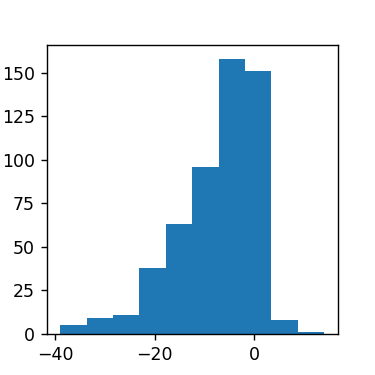

<IPython.core.display.Javascript object>


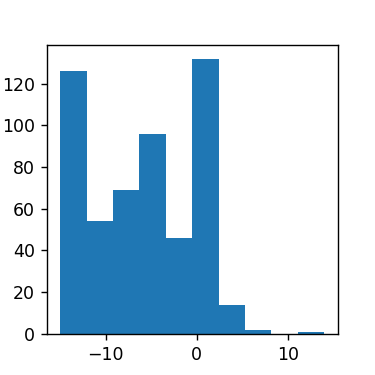

<IPython.core.display.Javascript object>


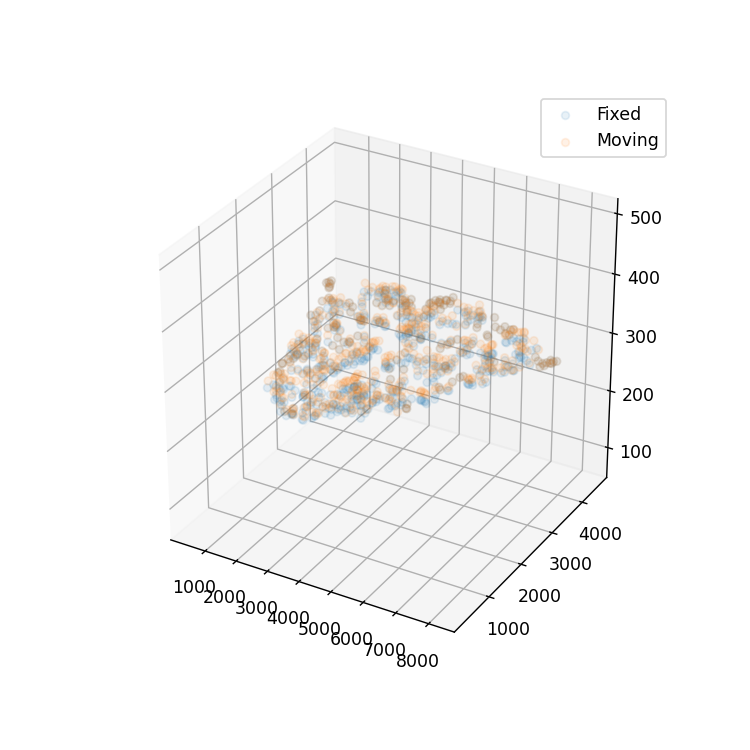

Number of feature matches: 646
Number of RANSAC matches: 540


In [138]:
# Specially for this, we clip all z_differences to be at a max. difference (otherwise get weird stuff happening)
max_z_difference = 15


#############
plt.figure(figsize=(3,3))
plt.hist(fixed_coords_r[:,2]-moving_coords_r[:,2])
plt.show()

fixed_less = fixed_coords_r[np.abs(fixed_coords_r[:,2]-moving_coords_r[:,2]) <= max_z_difference]
moving_less = moving_coords_r[np.abs(fixed_coords_r[:,2]-moving_coords_r[:,2]) <= max_z_difference]
fixed_more = fixed_coords_r[np.abs(fixed_coords_r[:,2]-moving_coords_r[:,2]) > max_z_difference]
moving_more = moving_coords_r[np.abs(fixed_coords_r[:,2]-moving_coords_r[:,2]) > max_z_difference]
diffs =  fixed_more[:,2]-moving_more[:,2]
diffs_new = diffs.copy()
diffs_new[diffs>0] -= max_z_difference
diffs_new[diffs<0] += max_z_difference 

# modify the moving coordinates
moving_more[:,2] += diffs_new
fixed_new = np.concatenate((fixed_more,fixed_less),axis=0)
moving_new = np.concatenate((moving_more,moving_less),axis=0)

plt.figure(figsize=(3,3))
plt.hist(fixed_new[:,2]-moving_new[:,2])
plt.show()

#Plot these coordinates
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(fixed_new[:,0],fixed_new[:,1],fixed_new[:,2],antialiased=True, alpha=0.1)
ax.scatter(moving_new[:,0],moving_new[:,1],moving_new[:,2],antialiased=True,alpha=0.1)
ax.set_zlim3d(fixed_coords_r[:,2].min()-200,fixed_coords_r[:,2].max()+200)
ax.legend(['Fixed','Moving'])


print("Number of feature matches:",fixed_coords_matched.shape[0])
print("Number of RANSAC matches:",fixed_new.shape[0])


np.save(fixed_coords_ransac_path, fixed_new)
np.save(moving_coords_ransac_path, moving_new)

[[ 9.99998122e-01 -1.90400016e-03  3.62332434e-04]
 [ 1.90435733e-03  9.99997699e-01 -9.87972667e-04]
 [-3.60450500e-04  9.88660822e-04  9.99999446e-01]] [[  6.37011801]
 [-16.92034631]
 [ -7.64502436]]


<IPython.core.display.Javascript object>


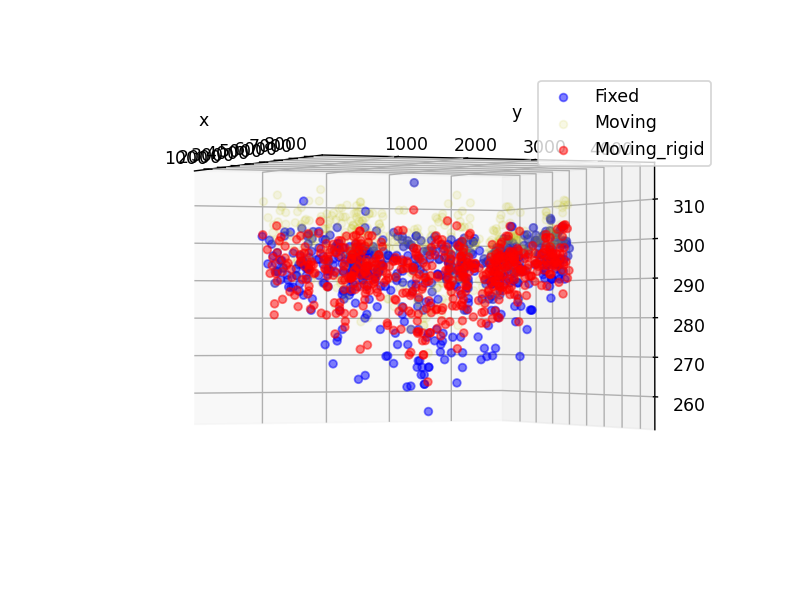

In [139]:
# Perform a rigid transform first with all these points...
flattened_arteries_path = bdir(name_prefix+'_anchors_ransac.npy') # top slab, bottom side
flattened_arteries_path2 = bdir(name_prefix2+'_anchors_ransac.npy') # bottom slab, top side 
plot2d = False # if False, plot points in 3d
use2d = False # don't use 3d, the nonplanar rotation is too sensitive to the endpoint detection
R_path = bdir('R_r1.npy')
b_path = bdir('b_r1.npy')

###############################################
flattened_arteries = np.load(flattened_arteries_path)
flattened_arteries_2 = np.load(flattened_arteries_path2)

# if doing 2d
if use2d:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2[:,:2]), np.transpose(flattened_arteries[:,:2]))
    new_pts = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2[:,:2])) + b)
    new_points = np.concatenate((new_pts,flattened_arteries_2[:,2:3]),axis=1) # add in the z coordinate
    
    # needs to be 3x3 for future transforms
    Rn = np.zeros((3,3))
    Rn[:2,:2] = R
    Rn[2,2] = 1
    bn = np.zeros((3,))
    R = Rn
    b = bn
    
# 3d
else:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2), np.transpose(flattened_arteries))
    new_points = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2)) + b)
    print(R,b)
    # we don't want to screw with the z coordinate translation
    b[2] = 0

np.save(R_path, R)
np.save(b_path, b.squeeze())

# 2D
fig = plt.figure()

if plot2d:
    ax = fig.add_subplot(1,1,1)#,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1, color='r')
    ax.scatter(new_points[:,0],new_points[:,1],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])

#3d
else:
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],flattened_arteries[:,2],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],flattened_arteries_2[:,2],antialiased=True, alpha=0.1,color='y')
    ax.scatter(new_points[:,0],new_points[:,1],new_points[:,2],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])


In [140]:
# I/O 
# Due to the high nuclei background we use completely manually labelled points 


moving_pts_paths = [bdir(name_prefix2+'_anchors_ransac.npy')]#[bdir(name_prefix2+'_anchorwarp_anchor_pts.npy')]
fixed_pts_paths =  [bdir(name_prefix+'_anchors_ransac.npy')]#[bdir(name_prefix+'_anchorwarp_anchor_pts.npy')]

fixed_zarr_path = bdir(name_prefix+'_flattened.zarr')
moving_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r1.zarr')


# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers = 8 

# affine parameters 
R_path = bdir('R_r1.npy')
b_path = bdir('b_r1.npy')

# grid I/O 
save_grid_values_path = bdir('grid_tps_r1_ransac.npy')
use_grid_values_path = None

# anchor parameters (using the surface on the other side and manually identified anchors on the cut surface)
static_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')]#,
                   #bdir(name_prefix+'_anchor_pts_flat.npy')]

##########################

TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Fitting radial basis function...
Fitting rbf took 89.170575 seconds
Nonrigid ave. distance [pixels]: 0.002711952824951333
Warping grid...
Warping grid took 426.387802 seconds
Saved grid_values at /mnt/beegfs/webster/fig3_dfly/grid_tps_r1_ransac.npy
Warping image...


100%|██████████| 3096/3096 [06:19<00:00,  8.15it/s]


Time elapsed: 21.433298 minutes
Loading z 0 - 200


100%|██████████| 200/200 [04:59<00:00,  1.42s/it]


Loading z 200 - 400


100%|██████████| 200/200 [05:18<00:00,  1.62s/it]


Loading z 400 - 556


100%|██████████| 156/156 [04:02<00:00,  1.62s/it]


In [143]:

# Get inverse R,b 
R_path = bdir('R.npy')
b_path = bdir('b.npy')
R = np.load(R_path); b = np.load(b_path)
Rinv,binv = get_inverse_rigid_transform(R,b)
np.save(bdir('Rinv.npy'),Rinv)
np.save(bdir('binv.npy'),binv)

In [144]:
# FIrst we have to transform all of the bottom_r1 labelled points back into the flattened frame

moving_pts_paths = [bdir(name_prefix+'_anchor_pts_flat.npy')] # these are switched from normal
fixed_pts_paths =  [bdir(name_prefix2+'_anchor_pts_flat.npy')]

pts_transform_paths = [bdir(name_prefix2+'_anchorwarp_anchor_pts.npy')] # transform both of these back to the anchorwarp frame
pts_transform_save_paths = [bdir(name_prefix2+'_anchorwarp_anchor_pts_flat.npy')] 

# Other surface points for anchoring the transformation
static_pts_path = [bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')]

# Affine parameters, need to actually get the inverse of this 
R_path = bdir('Rinv.npy')
b_path = bdir('binv.npy')

##############################
# TPS transform    
_ = TPS_transform_points(moving_pts_paths, fixed_pts_paths, pts_masked_paths=pts_transform_paths, 
                     pts_masked_save_paths=pts_transform_save_paths, static_pts_paths=static_pts_paths, 
                    R_path=R_path, b_path=b_path)

Fitting radial basis function...
Fitting rbf took 62.976314 seconds


In [148]:
moving_pts_paths = [bdir(name_prefix2+'_anchor_pts_flat.npy'),
                   bdir(name_prefix2+'_anchorwarp_anchor_pts_flat.npy')]
fixed_pts_paths =  [bdir(name_prefix+'_anchor_pts_flat.npy'),
                   bdir(name_prefix+'_anchorwarp_anchor_pts.npy')]

fixed_zarr_path = bdir(name_prefix+'_flattened.zarr')
moving_zarr_path = bdir(name_prefix2+'_flattened.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_allanchors.zarr')


# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers = 8 

# affine parameters 
R_path = bdir('R.npy')
b_path = bdir('b.npy')

# grid I/O 
save_grid_values_path = bdir('grid_anchor_tps_allanchors.npy')
use_grid_values_path = None

# anchor parameters (using the surface on the other side and manually identified anchors on the cut surface)
static_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')]

##########################

TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Fitting radial basis function...
Fitting rbf took 93.848918 seconds
Nonrigid ave. distance [pixels]: 0.00041231027936191776
Warping grid...
Warping grid took 462.484460 seconds
Saved grid_values at /mnt/beegfs/webster/fig3_dfly/grid_anchor_tps_allanchors.npy
Warping image...


100%|██████████| 3096/3096 [07:52<00:00,  4.41it/s]


Time elapsed: 26.107373 minutes
Loading z 0 - 200


100%|██████████| 200/200 [04:57<00:00,  1.40s/it]


Loading z 200 - 400


100%|██████████| 200/200 [05:13<00:00,  1.38s/it]


Loading z 400 - 556


100%|██████████| 156/156 [04:05<00:00,  1.55s/it]


## Round 2

Relabel some more points, transform back to flattened space, then warp everything

[Return to top](#top)

<a id='round2'></a>

In [149]:
# Read in JSON file with newly labelled 

# Load in the new anchor points (combine the old anchor points with the new ones)

json_path = bdir('r1_anchorpts.json')
new_anchor_pts_moving_path = bdir(name_prefix2+'_anchorwarp_anchor_pts_r2.npy')
new_anchor_pts_fixed_path = bdir(name_prefix+'_anchorwarp_anchor_pts_r2.npy')
moving_name = 'points_4'
fixed_name = 'points_3'

##############
moving_pts_new = read_annotations_json(json_path, moving_name, sink_path=new_anchor_pts_moving_path)
fixed_pts_new = read_annotations_json(json_path, fixed_name, sink_path=new_anchor_pts_fixed_path)


# Also save individually in JSON so that we can visualize 
numpy_to_json(fixed_pts_new, new_anchor_pts_fixed_path[:-4]+'.json')
numpy_to_json(moving_pts_new, new_anchor_pts_moving_path[:-4]+'.json')
print(moving_pts_new.shape, fixed_pts_new.shape)

(53, 3) (53, 3)


In [150]:
# FIrst we have to transform all of the bottom_r1 labelled points back into the flattened frame

moving_pts_paths = [bdir(name_prefix+'_anchor_pts_flat.npy'),
                   bdir(name_prefix+'_anchorwarp_anchor_pts.npy')] # these are switched from normal
fixed_pts_paths =  [bdir(name_prefix2+'_anchor_pts_flat.npy'),
                   bdir(name_prefix2+'_anchorwarp_anchor_pts_flat.npy')]

pts_transform_paths = [bdir(name_prefix2+'_anchorwarp_anchor_pts_r2.npy')] # transform both of these back to the anchorwarp frame
pts_transform_save_paths = [bdir(name_prefix2+'_anchorwarp_anchor_pts_r2_flat.npy')] 

# Other surface points for anchoring the transformation
static_pts_path = [bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')]

# Affine parameters, need to actually get the inverse of this 
R_path = bdir('Rinv.npy')
b_path = bdir('binv.npy')

##############################
# TPS transform    
_ = TPS_transform_points(moving_pts_paths, fixed_pts_paths, pts_masked_paths=pts_transform_paths, 
                     pts_masked_save_paths=pts_transform_save_paths, static_pts_paths=static_pts_paths, 
                    R_path=R_path, b_path=b_path)

Fitting radial basis function...
Fitting rbf took 90.772248 seconds


In [258]:
moving_pts_paths = [bdir(name_prefix2+'_anchor_pts_flat.npy'),
                   bdir(name_prefix2+'_anchorwarp_anchor_pts_flat.npy'),
                   bdir(name_prefix2+'_anchorwarp_anchor_pts_r2_flat.npy')]
fixed_pts_paths =  [bdir(name_prefix+'_anchor_pts_flat.npy'),
                   bdir(name_prefix+'_anchorwarp_anchor_pts.npy'),
                   bdir(name_prefix+'_anchorwarp_anchor_pts_r2.npy')]

fixed_zarr_path = bdir(name_prefix+'_flattened.zarr')
moving_zarr_path = bdir(name_prefix2+'_flattened.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_allanchors_r2.zarr')


# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers = 8 

# affine parameters 
R_path = bdir('R.npy')
b_path = bdir('b.npy')

# grid I/O 
save_grid_values_path = bdir('grid_anchor_tps_allanchors_r2.npy')
use_grid_values_path = None

# anchor parameters (using the surface on the other side and manually identified anchors on the cut surface)
static_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_outlier_uv_new.npy')]

##########################

TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
# tiff_path = warped_zarr_path[:-5]+'_tiffs'
# convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Fitting radial basis function...
Fitting rbf took 87.104285 seconds
Nonrigid ave. distance [pixels]: 0.0004993119787503188
Warping grid...
Warping grid took 488.130182 seconds
Saved grid_values at /mnt/beegfs/webster/fig3_dfly/grid_anchor_tps_allanchors_r2.npy
Warping image...


100%|██████████| 3096/3096 [07:12<00:00,  5.08it/s]


Time elapsed: 24.647480 minutes
